In [64]:
# main01.py is a part of the PYTHIA event generator.
# Copyright (C) 2023 Torbjorn Sjostrand.
# PYTHIA is licenced under the GNU GPL v2 or later, see COPYING for details.
# Please respect the MCnet Guidelines, see GUIDELINES for details.

# Keywords: basic usage; charged multiplicity; python;

# This is a simple test program. It fits on one slide in a talk.  It
# studies the charged multiplicity distribution at the LHC.

# To set the path to the Pythia 8 Python interface do either
# (in a shell prompt):
#      export PYTHONPATH=$(PREFIX_LIB):$PYTHONPATH
# or the following which sets the path from within Python.
import sys
cfg = open("../pythia8309/Makefile.inc")
lib = "../pythia8309/lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)

# Import the Pythia module.
import pythia8
'''
pythia = pythia8.Pythia()
pythia.readString("Beams:eCM = 8000.")
pythia.readString("HardQCD:all = on")
pythia.readString("SoftQCD:all = on")
pythia.readString("PhaseSpace:pTHatMin = 20.")
pythia.init()
'''

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split


In [65]:
import optuna

# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_slice

In [66]:
maxEvents = 10000
maxLength = 400

In [67]:
def generateData(pythia):

    mult = pythia8.Hist("charged multiplicity", 50, -0.5, 399.5)
    pT = pythia8.Hist("transverse momentum", 50, 0.0, 5.)
    
    data = np.zeros((1,maxLength,3))

    # Begin event loop. Generate event. Skip if error. List first one.
    nChargedMax = 0
    print("start")
    for iEvent in range(0, maxEvents):
        if iEvent%1000 == 0: print(iEvent)
        if not pythia.next(): continue
        # Find number of all final charged particles and fill histogram.
        event = np.zeros((maxLength,3))
    
        nCharged = 0
        for prt in pythia.event:
            if prt.isFinal() and prt.isCharged(): 
                if nCharged < maxLength:
                    event[nCharged,0] = prt.pT()
                    event[nCharged,1] = prt.theta()
                    event[nCharged,2] = prt.phi()
                    pT.fill(prt.pT())
                nCharged += 1
                #print(nCharged)
        if iEvent%1000 == 0: print("nCharged ",nCharged) 
        # sort event by pT
        #print(event)
        event = event[event[:, 0].argsort()[::-1]]
        #print(event)
        # from all Phi angles subtract the phi of the particle with the highest pT
        phi0 = event[0,2]
        for i in range(len(event)):
            event[i,2] = (event[i,2]-phi0)%(2.*np.pi)
            if event[i,2] > np.pi:
                event[i,2] = event[i,2] - 2*np.pi

        event = event.reshape((1,maxLength,3))        
        if iEvent > -1:   
            #print(event)
            data = np.concatenate((data, event), axis=0)
        else:
            #print(event)
            data = event    
        mult.fill(nCharged)
        if nCharged > nChargedMax:
            nChargedMax = nCharged
    
    # End of event loop. Statistics. Histogram. Done.
    print(data.shape)
    #pythia.stat();
    #print(mult)

    print("Max. nCharged = ", nChargedMax)

    return data, mult, pT

In [68]:
# generate data
#pythia = pythia8.Pythia()
#pythia.readString("Beams:eCM =  13.6 TeV")
#pythia.readString("HardQCD:all = on")
#pythia.readString("SoftQCD:all = on")
#pythia.readString("PhaseSpace:pTHatMin = 20.")

#pythia.readString("MultipartonInteractions:pT0Ref = 1")
#pythia.init()

In [69]:
def initPythia(pT0Ref, ecmPow, coreRadius, coreFraction):
    # generate data
    pythia = pythia8.Pythia()
    pythia.readString("Beams:eCM =  13600.")
    #pythia.readString("HardQCD:all = on")
    pythia.readString("SoftQCD:all = on")
    #pythia.readString("PhaseSpace:pTHatMin = 20.")

    auxstr = "MultipartonInteractions:pT0Ref = "+str(pT0Ref)
    pythia.readString(auxstr)
    auxstr = "MultipartonInteractions:ecmPow = "+str(ecmPow)
    pythia.readString(auxstr)  
    auxstr = "MultipartonInteractions:coreRadius = "+str(coreRadius)
    pythia.readString(auxstr)
    auxstr = "MultipartonInteractions:coreFraction = "+str(coreFraction)
    pythia.readString(auxstr) 

    pythia.init()

    return pythia




In [70]:

pythia = initPythia(1.5, 0.07, 0.7, 0.7)
data0, mult0, pT0 = generateData(pythia)

print("Data shape: ",data0.shape)

del pythia

start
0
nCharged  110
1000
nCharged  40
2000
nCharged  44
3000
nCharged  60
4000
nCharged  2
5000
nCharged  60
6000
nCharged  38
7000
nCharged  2
8000
nCharged  62
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  774
Data shape:  (10001, 400, 3)


(array([2644.,  306.,  317.,  404.,  560.,  683.,  519.,  332.,  272.,
         247.,  212.,  174.,  198.,  147.,  129.,  133.,  118.,  107.,
          99.,   97.,   91.,   91.,   88.,   91.,   70.,   94.,   67.,
          62.,   54.,   63.,   58.,   50.,   72.,   72.,   66.,   61.,
          49.,   45.,   52.,   53.,   38.,   41.,   41.,   52.,   46.,
          49.,   42.,   35.,   41.,   53.]),
 array([ -0.5,   7.5,  15.5,  23.5,  31.5,  39.5,  47.5,  55.5,  63.5,
         71.5,  79.5,  87.5,  95.5, 103.5, 111.5, 119.5, 127.5, 135.5,
        143.5, 151.5, 159.5, 167.5, 175.5, 183.5, 191.5, 199.5, 207.5,
        215.5, 223.5, 231.5, 239.5, 247.5, 255.5, 263.5, 271.5, 279.5,
        287.5, 295.5, 303.5, 311.5, 319.5, 327.5, 335.5, 343.5, 351.5,
        359.5, 367.5, 375.5, 383.5, 391.5, 399.5]),
 [<matplotlib.patches.Polygon at 0x7f1430cfd1b0>])

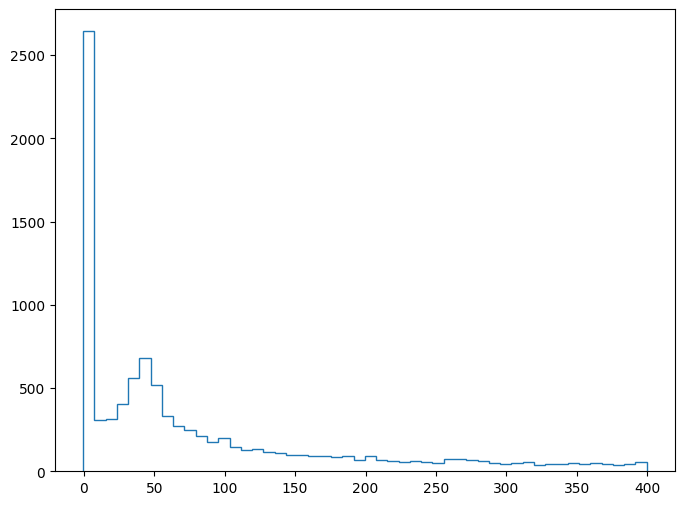

In [71]:
import matplotlib.pyplot as plt

plt.hist(mult0.getBinEdges()[:-1], mult0.getBinEdges(), 
               weights = mult0.getBinContents(), 
               histtype = "step", label = mult0.getTitle()) 

#print(mult)

(array([7.09920e+04, 1.46182e+05, 1.54201e+05, 1.34345e+05, 1.08122e+05,
        8.31920e+04, 6.28230e+04, 4.76560e+04, 3.54240e+04, 2.68790e+04,
        2.08490e+04, 1.67770e+04, 1.35830e+04, 1.12820e+04, 9.17900e+03,
        7.77600e+03, 6.31800e+03, 5.42200e+03, 4.49400e+03, 3.74200e+03,
        3.26900e+03, 2.75100e+03, 2.28700e+03, 2.00800e+03, 1.75000e+03,
        1.47200e+03, 1.23200e+03, 1.03800e+03, 9.18000e+02, 7.73000e+02,
        6.80000e+02, 6.11000e+02, 5.28000e+02, 4.26000e+02, 3.38000e+02,
        3.39000e+02, 3.18000e+02, 2.77000e+02, 2.36000e+02, 1.89000e+02,
        1.71000e+02, 1.39000e+02, 1.23000e+02, 1.22000e+02, 1.00000e+02,
        7.80000e+01, 7.50000e+01, 6.80000e+01, 5.00000e+01, 5.50000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4

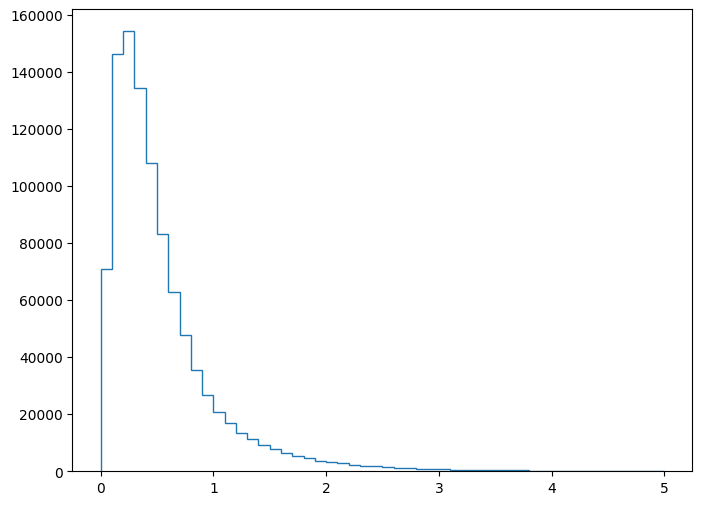

In [72]:
plt.hist(pT0.getBinEdges()[:-1], pT0.getBinEdges(), 
               weights = pT0.getBinContents(), 
               histtype = "step", label = pT0.getTitle()) 

# Implement neural network

In [73]:
def prepareData(data0,data):
    X = np.concatenate((data0,data), axis=0)
    X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

    y = np.zeros((X.shape[0],2))
    y[:data0.shape[0],0] = 1
    y[data0.shape[0]:,1] = 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, shuffle=True, random_state=42)
    return X_train, X_test, y_train, y_test

In [74]:
def createModel(shape):
    # Here is the fully connected (dense) network
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model

In [75]:
def trainModel(model, X_train, X_test, y_train, y_test):
    batch_size = 128
    epochs = 20

    history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))
    return history

In [76]:
def plotAccuracy(history):
    # Plots for training and testing process: loss and accuracy


    n_epochs = len(history.history['accuracy'])

    plt.figure(0)
    plt.plot(history.history['accuracy'],'r')
    plt.plot(history.history['val_accuracy'],'g')
    plt.xticks(np.arange(0, n_epochs, 10.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['train','validation'])
    plt.show()

In [77]:
def plotLoss(history):

    n_epochs = len(history.history['loss'])
    
    plt.figure(1)
    plt.plot(history.history['loss'],'r')
    plt.plot(history.history['val_loss'],'g')
    plt.xticks(np.arange(0, n_epochs, 10.0))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Validation Loss")
    plt.legend(['train','validation'])
    plt.show()

In [78]:
def optimize(data0,pT0Ref,ecmPow,coreRadius,coreFraction):
    
    pythia = initPythia(pT0Ref,ecmPow,coreRadius,coreFraction)
    print("Pythia initialized")
    data, mult, pT = generateData(pythia)

    print("Data shape: ",data.shape)

    del pythia
    
    ###
    
    X_train, X_test, y_train, y_test = prepareData(data0,data)
    model = createModel(shape=X_train.shape[1])
    history = trainModel(model, X_train, X_test, y_train, y_test)
    plotLoss(history)
    #accuracy = np.max(history.history['val_accuracy'])
    loss = np.min(history.history['val_loss'])
    del model

    return loss

[I 2023-07-07 07:52:56,319] A new study created in memory with name: no-name-f119ee6e-a66c-48bf-ba84-766eb8bccb51


Optuna suggested x =  1.7820238205319945 0.36862894395487056 0.9457038779485177 0.7032747745530993
Pythia initialized
start
0
nCharged  102
1000
nCharged  38
2000
nCharged  70
3000
nCharged  2
4000
nCharged  56
5000
nCharged  2
6000
nCharged  2
7000
nCharged  2
8000
nCharged  36
9000
nCharged  158
(10001, 400, 3)
Max. nCharged =  560
Data shape:  (10001, 400, 3)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 64)                76864     
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 64)                4160      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                  

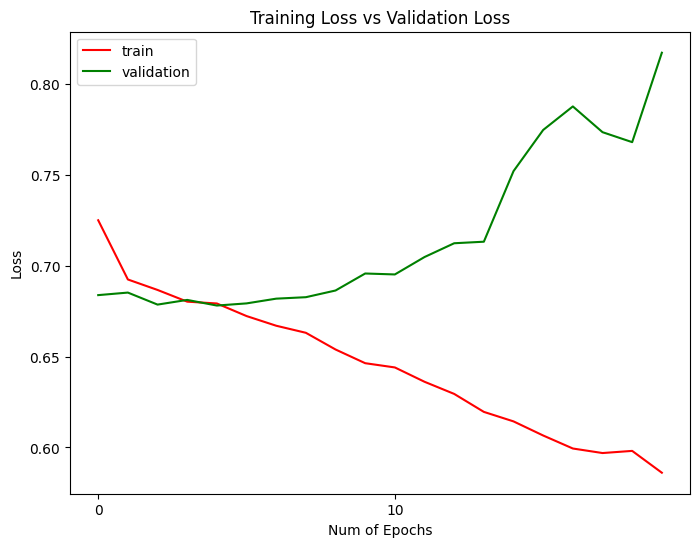

[I 2023-07-07 07:55:52,073] Trial 0 finished with value: 0.6781632304191589 and parameters: {'pT0Ref': 1.7820238205319945, 'ecmPow': 0.36862894395487056, 'coreRadius': 0.9457038779485177, 'coreFraction': 0.7032747745530993}. Best is trial 0 with value: 0.6781632304191589.


Optuna suggested x =  2.562986034750732 0.10628501884491251 0.7583969416413217 0.6977652872097546
Pythia initialized
start
0
nCharged  2
1000
nCharged  2
2000
nCharged  50
3000
nCharged  52
4000
nCharged  112
5000
nCharged  160
6000
nCharged  2
7000
nCharged  42
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  458
Data shape:  (10001, 400, 3)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 64)                76864     
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 64)                4160      
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                    

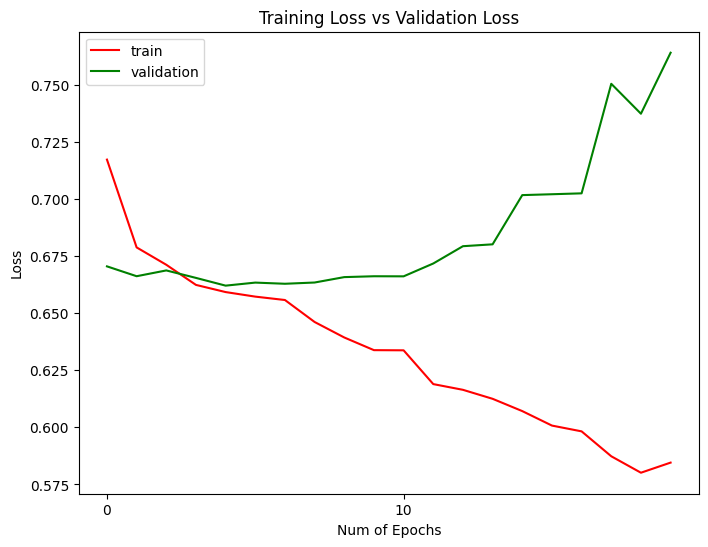

[I 2023-07-07 07:59:06,815] Trial 1 finished with value: 0.6620717644691467 and parameters: {'pT0Ref': 2.562986034750732, 'ecmPow': 0.10628501884491251, 'coreRadius': 0.7583969416413217, 'coreFraction': 0.6977652872097546}. Best is trial 0 with value: 0.6781632304191589.


Optuna suggested x =  1.4381333139403822 0.356615796765021 0.2576727212674915 0.7037281741286638
Pythia initialized
start
0
nCharged  2
1000
nCharged  296
2000
nCharged  2
3000
nCharged  80
4000
nCharged  316
5000
nCharged  26
6000
nCharged  186
7000
nCharged  36
8000
nCharged  48
9000
nCharged  38
(10001, 400, 3)
Max. nCharged =  608
Data shape:  (10001, 400, 3)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 64)                76864     
                                                                 
 dropout_42 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 64)                4160      
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                 

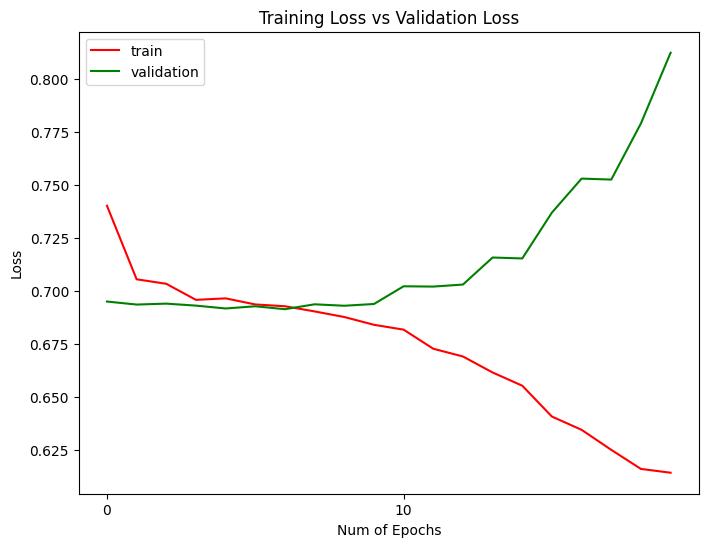

[I 2023-07-07 08:02:25,527] Trial 2 finished with value: 0.691428542137146 and parameters: {'pT0Ref': 1.4381333139403822, 'ecmPow': 0.356615796765021, 'coreRadius': 0.2576727212674915, 'coreFraction': 0.7037281741286638}. Best is trial 2 with value: 0.691428542137146.


Optuna suggested x =  2.3587348379453887 0.37726219047973364 0.8893463173773622 0.7010442373339233
Pythia initialized
start
0
nCharged  46
1000
nCharged  2
2000
nCharged  230
3000
nCharged  4
4000
nCharged  60
5000
nCharged  38
6000
nCharged  2
7000
nCharged  98
8000
nCharged  68
9000
nCharged  40
(10001, 400, 3)
Max. nCharged =  402
Data shape:  (10001, 400, 3)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                76864     
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 64)                4160      
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                  

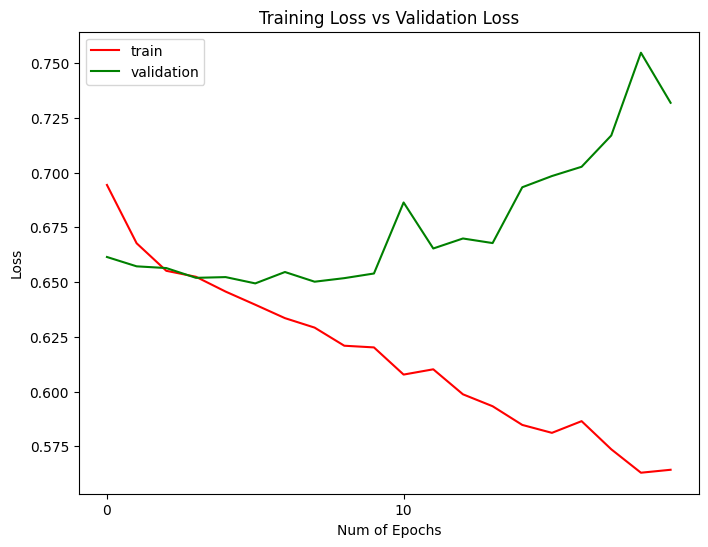

[I 2023-07-07 08:05:16,283] Trial 3 finished with value: 0.6494135856628418 and parameters: {'pT0Ref': 2.3587348379453887, 'ecmPow': 0.37726219047973364, 'coreRadius': 0.8893463173773622, 'coreFraction': 0.7010442373339233}. Best is trial 2 with value: 0.691428542137146.


Optuna suggested x =  3.651647490980894 0.13638663618820027 0.16969773394020737 0.7010938981988009
Pythia initialized
start
0
nCharged  36
1000
nCharged  76
2000
nCharged  2
3000
nCharged  34
4000
nCharged  36
5000
nCharged  28
6000
nCharged  52
7000
nCharged  10
8000
nCharged  74
9000
nCharged  76
(10001, 400, 3)
Max. nCharged =  292
Data shape:  (10001, 400, 3)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 64)                76864     
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                                 
 dense_65 (Dense)            (None, 64)                4160      
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                 

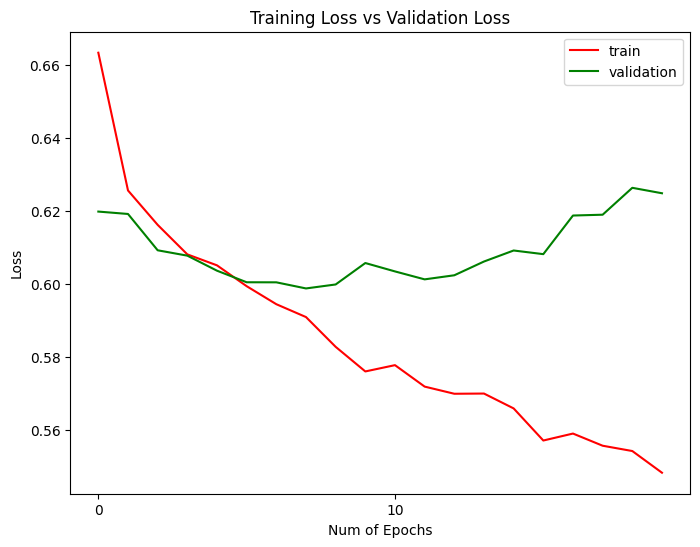

[I 2023-07-07 08:08:35,474] Trial 4 finished with value: 0.5988631248474121 and parameters: {'pT0Ref': 3.651647490980894, 'ecmPow': 0.13638663618820027, 'coreRadius': 0.16969773394020737, 'coreFraction': 0.7010938981988009}. Best is trial 2 with value: 0.691428542137146.


Optuna suggested x =  1.5096793153528705 0.3088045430576571 0.7706094336780539 0.6933952123764211
Pythia initialized
start
0
nCharged  2
1000
nCharged  134
2000
nCharged  28
3000
nCharged  106
4000
nCharged  8
5000
nCharged  66
6000
nCharged  64
7000
nCharged  448
8000
nCharged  2
9000
nCharged  196
(10001, 400, 3)
Max. nCharged =  692
Data shape:  (10001, 400, 3)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 64)                76864     
                                                                 
 dropout_51 (Dropout)        (None, 64)                0         
                                                                 
 dense_69 (Dense)            (None, 64)                4160      
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
                

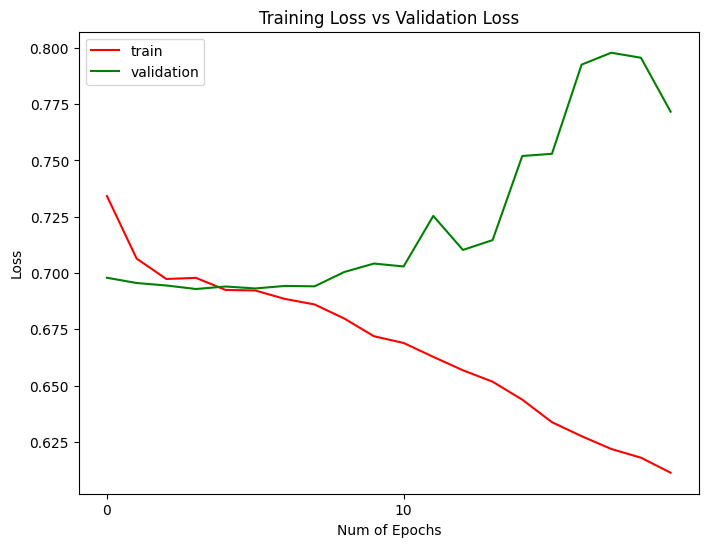

[I 2023-07-07 08:11:29,080] Trial 5 finished with value: 0.6928833723068237 and parameters: {'pT0Ref': 1.5096793153528705, 'ecmPow': 0.3088045430576571, 'coreRadius': 0.7706094336780539, 'coreFraction': 0.6933952123764211}. Best is trial 5 with value: 0.6928833723068237.


Optuna suggested x =  3.079401447108032 0.25769252463412917 0.95993286791288 0.6979727961758886
Pythia initialized
start
0
nCharged  90
1000
nCharged  118
2000
nCharged  2
3000
nCharged  128
4000
nCharged  76
5000
nCharged  2
6000
nCharged  50
7000
nCharged  22
8000
nCharged  34
9000
nCharged  40
(10001, 400, 3)
Max. nCharged =  280
Data shape:  (10001, 400, 3)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 64)                76864     
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_73 (Dense)            (None, 64)                4160      
                                                                 
 dropout_55 (Dropout)        (None, 64)                0         
                   

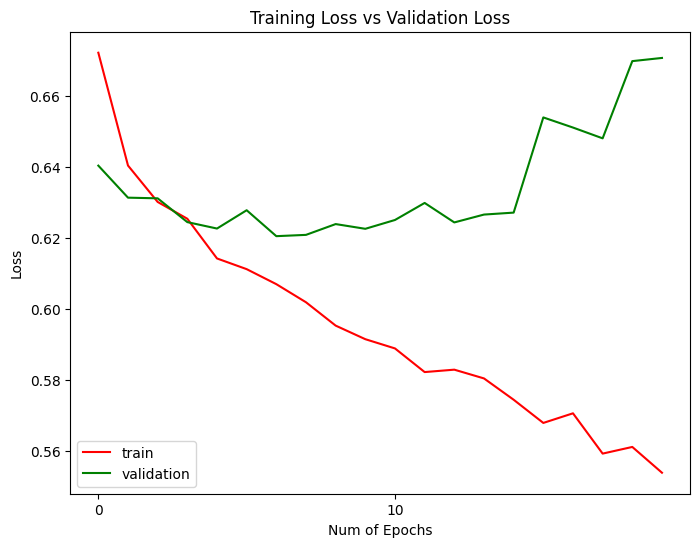

[I 2023-07-07 08:14:11,598] Trial 6 finished with value: 0.6204560995101929 and parameters: {'pT0Ref': 3.079401447108032, 'ecmPow': 0.25769252463412917, 'coreRadius': 0.95993286791288, 'coreFraction': 0.6979727961758886}. Best is trial 5 with value: 0.6928833723068237.


Optuna suggested x =  1.74718130245866 0.3935536297190756 0.7330195758252823 0.6926046263084152
Pythia initialized
start
0
nCharged  288
1000
nCharged  2
2000
nCharged  2
3000
nCharged  62
4000
nCharged  82
5000
nCharged  108
6000
nCharged  2
7000
nCharged  38
8000
nCharged  68
9000
nCharged  80
(10001, 400, 3)
Max. nCharged =  582
Data shape:  (10001, 400, 3)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 64)                76864     
                                                                 
 dropout_57 (Dropout)        (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 64)                4160      
                                                                 
 dropout_58 (Dropout)        (None, 64)                0         
                    

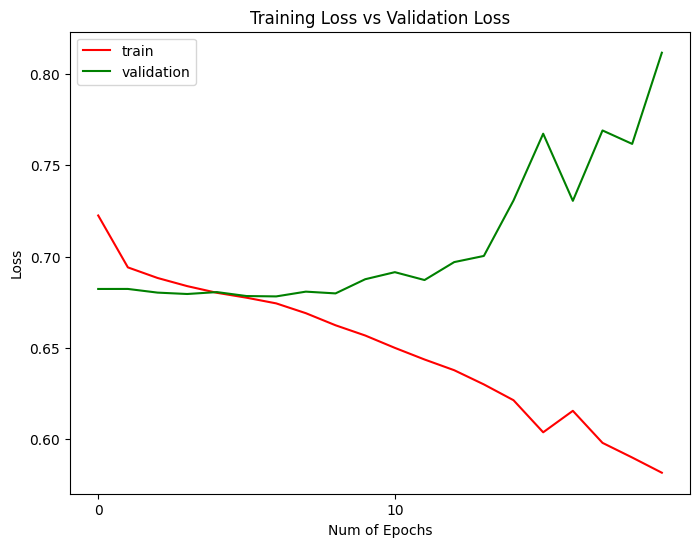

[I 2023-07-07 08:17:18,382] Trial 7 finished with value: 0.6781482696533203 and parameters: {'pT0Ref': 1.74718130245866, 'ecmPow': 0.3935536297190756, 'coreRadius': 0.7330195758252823, 'coreFraction': 0.6926046263084152}. Best is trial 5 with value: 0.6928833723068237.


Optuna suggested x =  3.34071883713651 0.2321602722361136 0.7965803512538838 0.6920094138175181
Pythia initialized
start
0
nCharged  64
1000
nCharged  2
2000
nCharged  2
3000
nCharged  18
4000
nCharged  38
5000
nCharged  56
6000
nCharged  72
7000
nCharged  2
8000
nCharged  36
9000
nCharged  94
(10001, 400, 3)
Max. nCharged =  278
Data shape:  (10001, 400, 3)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 64)                76864     
                                                                 
 dropout_60 (Dropout)        (None, 64)                0         
                                                                 
 dense_81 (Dense)            (None, 64)                4160      
                                                                 
 dropout_61 (Dropout)        (None, 64)                0         
                      

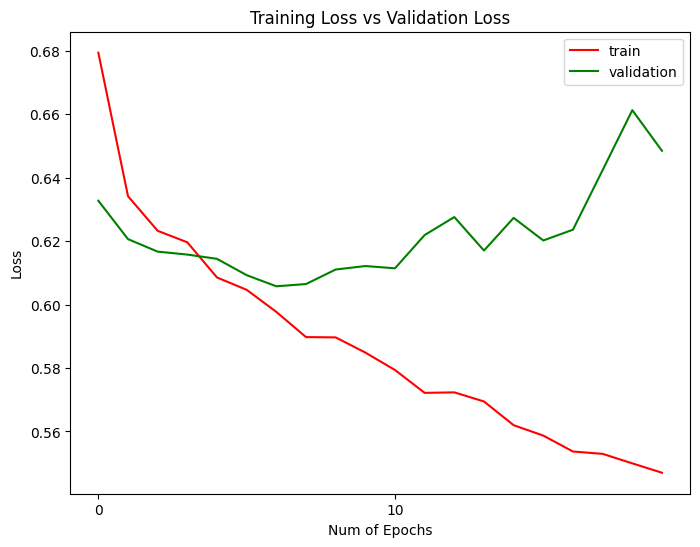

[I 2023-07-07 08:20:03,933] Trial 8 finished with value: 0.6057723164558411 and parameters: {'pT0Ref': 3.34071883713651, 'ecmPow': 0.2321602722361136, 'coreRadius': 0.7965803512538838, 'coreFraction': 0.6920094138175181}. Best is trial 5 with value: 0.6928833723068237.


Optuna suggested x =  2.3471350770210533 0.3218073049501048 0.803203128104262 0.6997893833651524
Pythia initialized
start
0
nCharged  50
1000
nCharged  2
2000
nCharged  18
3000
nCharged  2
4000
nCharged  130
5000
nCharged  2
6000
nCharged  122
7000
nCharged  170
8000
nCharged  2
9000
nCharged  174
(10001, 400, 3)
Max. nCharged =  426
Data shape:  (10001, 400, 3)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 64)                76864     
                                                                 
 dropout_63 (Dropout)        (None, 64)                0         
                                                                 
 dense_85 (Dense)            (None, 64)                4160      
                                                                 
 dropout_64 (Dropout)        (None, 64)                0         
                  

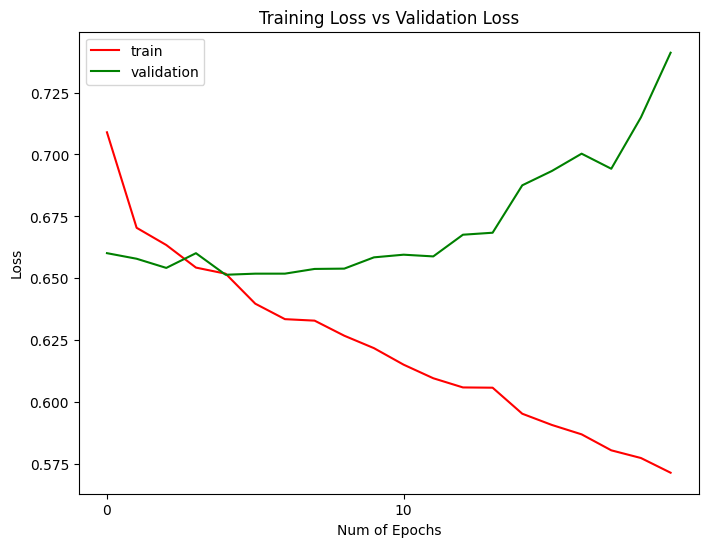

[I 2023-07-07 08:22:38,518] Trial 9 finished with value: 0.6514330506324768 and parameters: {'pT0Ref': 2.3471350770210533, 'ecmPow': 0.3218073049501048, 'coreRadius': 0.803203128104262, 'coreFraction': 0.6997893833651524}. Best is trial 5 with value: 0.6928833723068237.


Optuna suggested x =  0.5952443452827685 0.2918770571649873 0.5361415587032827 0.7070593478020389
Pythia initialized
start
0
nCharged  2
1000
nCharged  10
2000
nCharged  38
3000
nCharged  652
4000
nCharged  2
5000
nCharged  36
6000
nCharged  36
7000
nCharged  36
8000
nCharged  82
9000
nCharged  54
(10001, 400, 3)
Max. nCharged =  808
Data shape:  (10001, 400, 3)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 64)                76864     
                                                                 
 dropout_66 (Dropout)        (None, 64)                0         
                                                                 
 dense_89 (Dense)            (None, 64)                4160      
                                                                 
 dropout_67 (Dropout)        (None, 64)                0         
                  

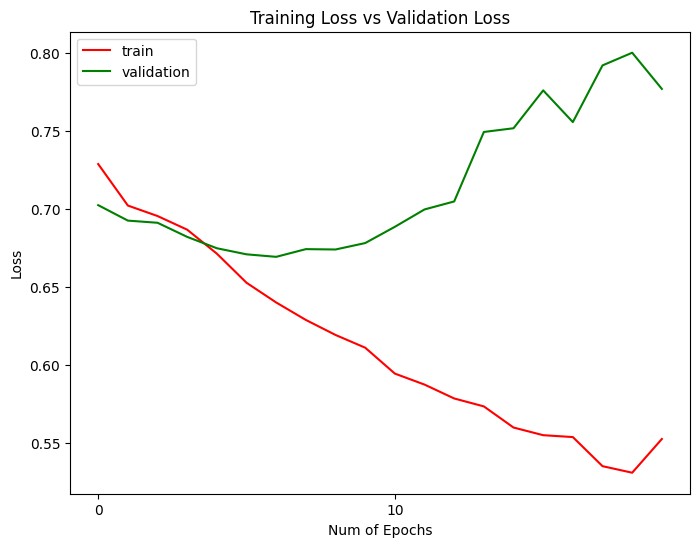

[I 2023-07-07 08:44:03,456] Trial 10 finished with value: 0.6692159175872803 and parameters: {'pT0Ref': 0.5952443452827685, 'ecmPow': 0.2918770571649873, 'coreRadius': 0.5361415587032827, 'coreFraction': 0.7070593478020389}. Best is trial 5 with value: 0.6928833723068237.


Optuna suggested x =  1.1241630419496236 0.325782311558908 0.24870464902778036 0.7094088784076261
Pythia initialized
start
0
nCharged  36
1000
nCharged  46
2000
nCharged  46
3000
nCharged  2
4000
nCharged  96
5000
nCharged  360
6000
nCharged  434
7000
nCharged  2
8000
nCharged  52
9000
nCharged  508
(10001, 400, 3)
Max. nCharged =  820
Data shape:  (10001, 400, 3)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 64)                76864     
                                                                 
 dropout_69 (Dropout)        (None, 64)                0         
                                                                 
 dense_93 (Dense)            (None, 64)                4160      
                                                                 
 dropout_70 (Dropout)        (None, 64)                0         
                

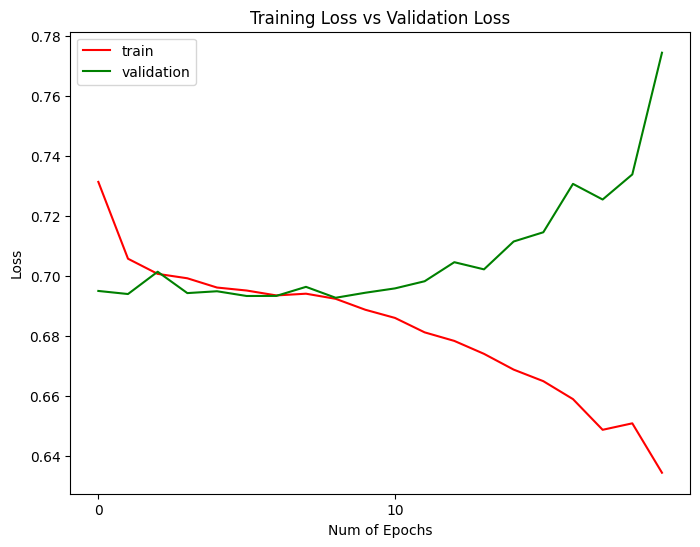

[I 2023-07-07 08:47:55,398] Trial 11 finished with value: 0.6926547884941101 and parameters: {'pT0Ref': 1.1241630419496236, 'ecmPow': 0.325782311558908, 'coreRadius': 0.24870464902778036, 'coreFraction': 0.7094088784076261}. Best is trial 5 with value: 0.6928833723068237.


Optuna suggested x =  0.9196909803918215 0.31019668868282363 0.420968991082742 0.7097898591108606
Pythia initialized
start
0
nCharged  48
1000
nCharged  2
2000
nCharged  36
3000
nCharged  88
4000
nCharged  8
5000
nCharged  182
6000
nCharged  454
7000
nCharged  56
8000
nCharged  434
9000
nCharged  52
(10001, 400, 3)
Max. nCharged =  836
Data shape:  (10001, 400, 3)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 64)                76864     
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_97 (Dense)            (None, 64)                4160      
                                                                 
 dropout_73 (Dropout)        (None, 64)                0         
                

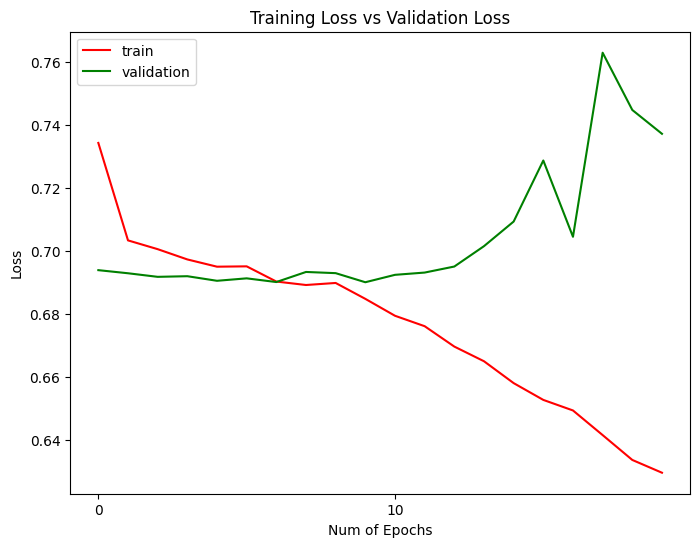

[I 2023-07-07 08:53:03,036] Trial 12 finished with value: 0.6900009512901306 and parameters: {'pT0Ref': 0.9196909803918215, 'ecmPow': 0.31019668868282363, 'coreRadius': 0.420968991082742, 'coreFraction': 0.7097898591108606}. Best is trial 5 with value: 0.6928833723068237.


Optuna suggested x =  1.1569458379342934 0.330941843437284 0.6210789876352861 0.6952405612327635
Pythia initialized
start
0
nCharged  160
1000
nCharged  12
2000
nCharged  54
3000
nCharged  374
4000
nCharged  364
5000
nCharged  82
6000
nCharged  44
7000
nCharged  2
8000
nCharged  32
9000
nCharged  52
(10001, 400, 3)
Max. nCharged =  738
Data shape:  (10001, 400, 3)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 64)                76864     
                                                                 
 dropout_75 (Dropout)        (None, 64)                0         
                                                                 
 dense_101 (Dense)           (None, 64)                4160      
                                                                 
 dropout_76 (Dropout)        (None, 64)                0         
                

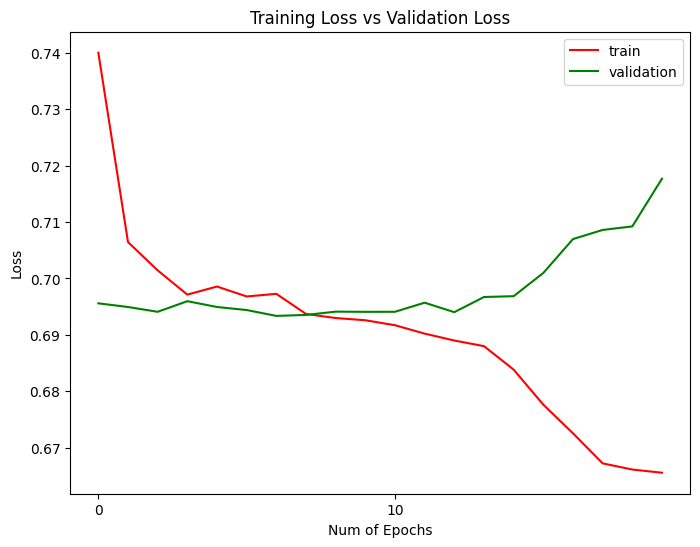

[I 2023-07-07 08:56:47,400] Trial 13 finished with value: 0.6933550834655762 and parameters: {'pT0Ref': 1.1569458379342934, 'ecmPow': 0.330941843437284, 'coreRadius': 0.6210789876352861, 'coreFraction': 0.6952405612327635}. Best is trial 13 with value: 0.6933550834655762.


Optuna suggested x =  1.357076347619952 0.26122430733817964 0.6316337799675108 0.6945194583895942
Pythia initialized
start
0
nCharged  58
1000
nCharged  2
2000
nCharged  82
3000
nCharged  74
4000
nCharged  118
5000
nCharged  62
6000
nCharged  82
7000
nCharged  30
8000
nCharged  224
9000
nCharged  26
(10001, 400, 3)
Max. nCharged =  684
Data shape:  (10001, 400, 3)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_104 (Dense)           (None, 64)                76864     
                                                                 
 dropout_78 (Dropout)        (None, 64)                0         
                                                                 
 dense_105 (Dense)           (None, 64)                4160      
                                                                 
 dropout_79 (Dropout)        (None, 64)                0         
                

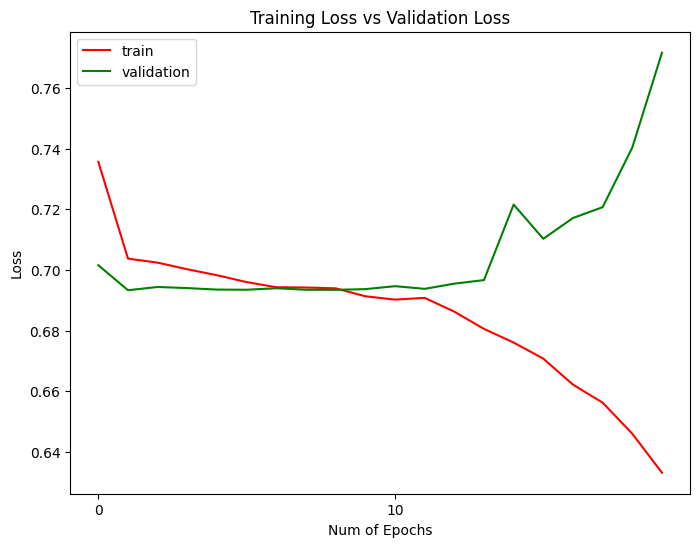

[I 2023-07-07 09:00:00,720] Trial 14 finished with value: 0.6933214664459229 and parameters: {'pT0Ref': 1.357076347619952, 'ecmPow': 0.26122430733817964, 'coreRadius': 0.6316337799675108, 'coreFraction': 0.6945194583895942}. Best is trial 13 with value: 0.6933550834655762.


Optuna suggested x =  0.5545888953261452 0.23793914204426528 0.6186625793489375 0.6949927920552982
Pythia initialized
start
0
nCharged  32
1000
nCharged  612
2000
nCharged  40
3000
nCharged  2
4000
nCharged  4
5000
nCharged  2
6000
nCharged  106
7000
nCharged  60
8000
nCharged  134
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  840
Data shape:  (10001, 400, 3)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 64)                76864     
                                                                 
 dropout_81 (Dropout)        (None, 64)                0         
                                                                 
 dense_109 (Dense)           (None, 64)                4160      
                                                                 
 dropout_82 (Dropout)        (None, 64)                0         
                 

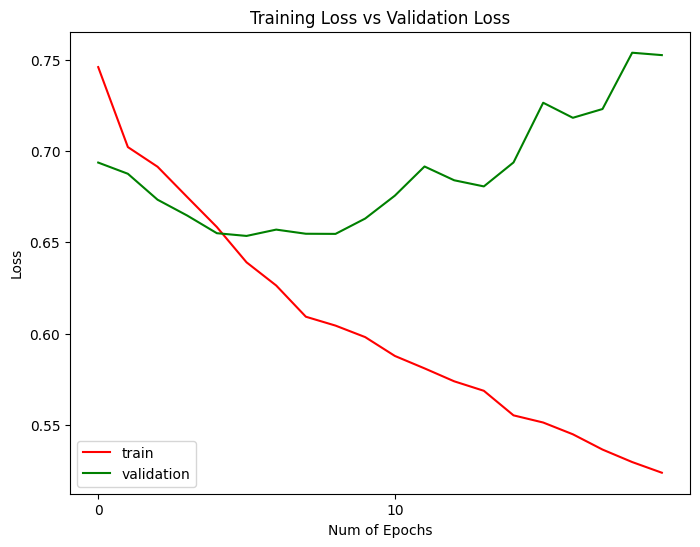

[I 2023-07-07 09:24:44,711] Trial 15 finished with value: 0.6535177826881409 and parameters: {'pT0Ref': 0.5545888953261452, 'ecmPow': 0.23793914204426528, 'coreRadius': 0.6186625793489375, 'coreFraction': 0.6949927920552982}. Best is trial 13 with value: 0.6933550834655762.


Optuna suggested x =  1.1998033593588728 0.19993899678182236 0.5723512643036589 0.6906595360023099
Pythia initialized
start
0
nCharged  10
1000
nCharged  2
2000
nCharged  458
3000
nCharged  38
4000
nCharged  44
5000
nCharged  416
6000
nCharged  50
7000
nCharged  188
8000
nCharged  100
9000
nCharged  62
(10001, 400, 3)
Max. nCharged =  722
Data shape:  (10001, 400, 3)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 64)                76864     
                                                                 
 dropout_84 (Dropout)        (None, 64)                0         
                                                                 
 dense_113 (Dense)           (None, 64)                4160      
                                                                 
 dropout_85 (Dropout)        (None, 64)                0         
             

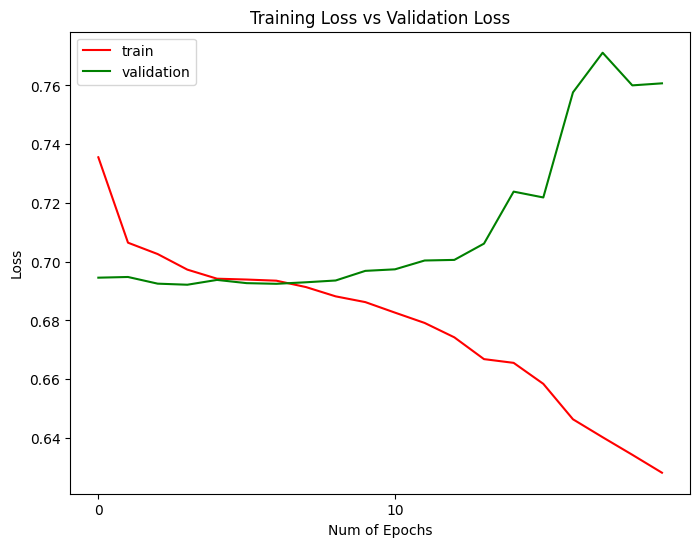

[I 2023-07-07 09:28:16,180] Trial 16 finished with value: 0.6921694278717041 and parameters: {'pT0Ref': 1.1998033593588728, 'ecmPow': 0.19993899678182236, 'coreRadius': 0.5723512643036589, 'coreFraction': 0.6906595360023099}. Best is trial 13 with value: 0.6933550834655762.


Optuna suggested x =  1.884552347928391 0.34944975357612407 0.46031405859298313 0.6953739034300168
Pythia initialized
start
0
nCharged  172
1000
nCharged  56
2000
nCharged  136
3000
nCharged  120
4000
nCharged  80
5000
nCharged  30
6000
nCharged  44
7000
nCharged  328
8000
nCharged  52
9000
nCharged  372
(10001, 400, 3)
Max. nCharged =  568
Data shape:  (10001, 400, 3)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 64)                76864     
                                                                 
 dropout_87 (Dropout)        (None, 64)                0         
                                                                 
 dense_117 (Dense)           (None, 64)                4160      
                                                                 
 dropout_88 (Dropout)        (None, 64)                0         
           

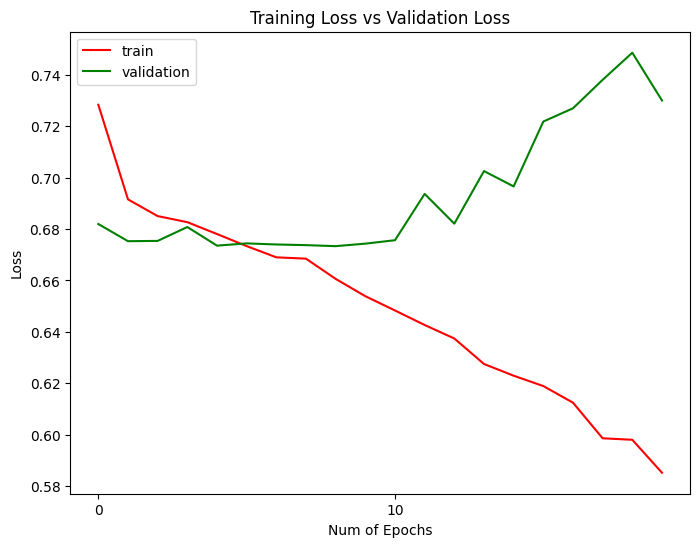

[I 2023-07-07 09:30:58,721] Trial 17 finished with value: 0.6733553409576416 and parameters: {'pT0Ref': 1.884552347928391, 'ecmPow': 0.34944975357612407, 'coreRadius': 0.46031405859298313, 'coreFraction': 0.6953739034300168}. Best is trial 13 with value: 0.6933550834655762.


Optuna suggested x =  0.908038665945867 0.2685824782424153 0.6693837563526317 0.6953798939777678
Pythia initialized
start
0
nCharged  274
1000
nCharged  2
2000
nCharged  68
3000
nCharged  292
4000
nCharged  2
5000
nCharged  570
6000
nCharged  204
7000
nCharged  590
8000
nCharged  134
9000
nCharged  30
(10001, 400, 3)
Max. nCharged =  812
Data shape:  (10001, 400, 3)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 64)                76864     
                                                                 
 dropout_90 (Dropout)        (None, 64)                0         
                                                                 
 dense_121 (Dense)           (None, 64)                4160      
                                                                 
 dropout_91 (Dropout)        (None, 64)                0         
              

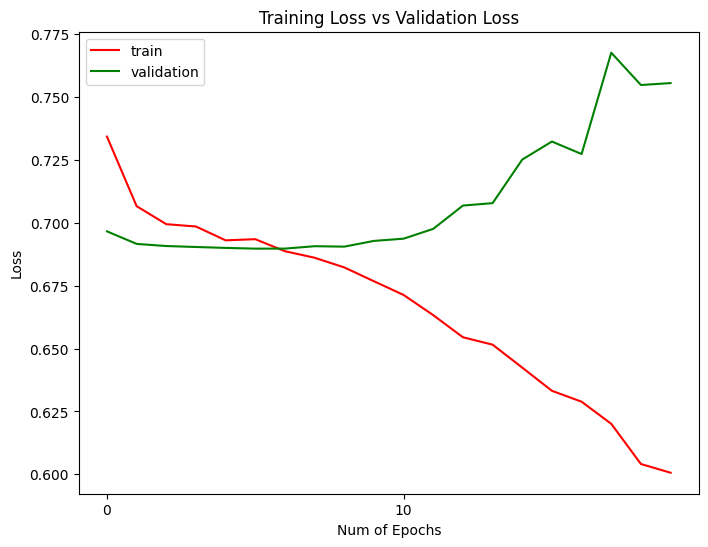

[I 2023-07-07 09:36:07,223] Trial 18 finished with value: 0.6897083520889282 and parameters: {'pT0Ref': 0.908038665945867, 'ecmPow': 0.2685824782424153, 'coreRadius': 0.6693837563526317, 'coreFraction': 0.6953798939777678}. Best is trial 13 with value: 0.6933550834655762.


Optuna suggested x =  2.052103383647072 0.2814244011640838 0.6378835563225828 0.6911203728949854
Pythia initialized
start
0
nCharged  2
1000
nCharged  24
2000
nCharged  60
3000
nCharged  224
4000
nCharged  158
5000
nCharged  44
6000
nCharged  2
7000
nCharged  58
8000
nCharged  52
9000
nCharged  224
(10001, 400, 3)
Max. nCharged =  502
Data shape:  (10001, 400, 3)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_124 (Dense)           (None, 64)                76864     
                                                                 
 dropout_93 (Dropout)        (None, 64)                0         
                                                                 
 dense_125 (Dense)           (None, 64)                4160      
                                                                 
 dropout_94 (Dropout)        (None, 64)                0         
                 

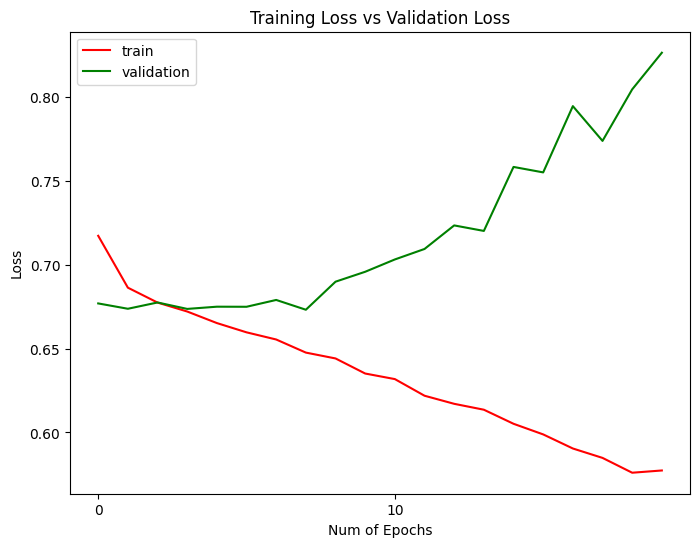

[I 2023-07-07 09:38:49,466] Trial 19 finished with value: 0.6732292771339417 and parameters: {'pT0Ref': 2.052103383647072, 'ecmPow': 0.2814244011640838, 'coreRadius': 0.6378835563225828, 'coreFraction': 0.6911203728949854}. Best is trial 13 with value: 0.6933550834655762.


Optuna suggested x =  1.4537435172924102 0.34999949609521414 0.49465991985573515 0.6900661404242465
Pythia initialized
start
0
nCharged  56
1000
nCharged  2
2000
nCharged  2
3000
nCharged  228
4000
nCharged  240
5000
nCharged  90
6000
nCharged  2
7000
nCharged  54
8000
nCharged  38
9000
nCharged  12
(10001, 400, 3)
Max. nCharged =  648
Data shape:  (10001, 400, 3)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 64)                76864     
                                                                 
 dropout_96 (Dropout)        (None, 64)                0         
                                                                 
 dense_129 (Dense)           (None, 64)                4160      
                                                                 
 dropout_97 (Dropout)        (None, 64)                0         
                

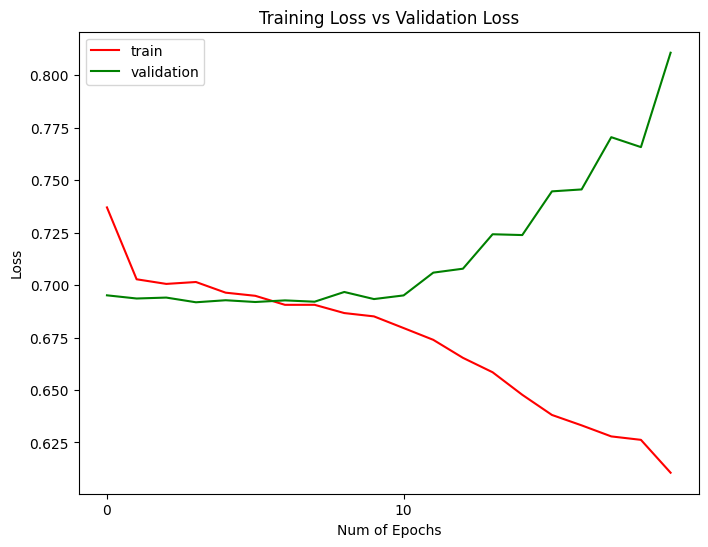

[I 2023-07-07 09:41:54,366] Trial 20 finished with value: 0.6917971968650818 and parameters: {'pT0Ref': 1.4537435172924102, 'ecmPow': 0.34999949609521414, 'coreRadius': 0.49465991985573515, 'coreFraction': 0.6900661404242465}. Best is trial 13 with value: 0.6933550834655762.


Optuna suggested x =  1.379657133064651 0.3127620260064772 0.6739594741124706 0.6931935870078225
Pythia initialized
start
0
nCharged  110
1000
nCharged  192
2000
nCharged  80
3000
nCharged  142
4000
nCharged  130
5000
nCharged  2
6000
nCharged  48
7000
nCharged  2
8000
nCharged  2
9000
nCharged  468
(10001, 400, 3)
Max. nCharged =  686
Data shape:  (10001, 400, 3)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 64)                76864     
                                                                 
 dropout_99 (Dropout)        (None, 64)                0         
                                                                 
 dense_133 (Dense)           (None, 64)                4160      
                                                                 
 dropout_100 (Dropout)       (None, 64)                0         
                

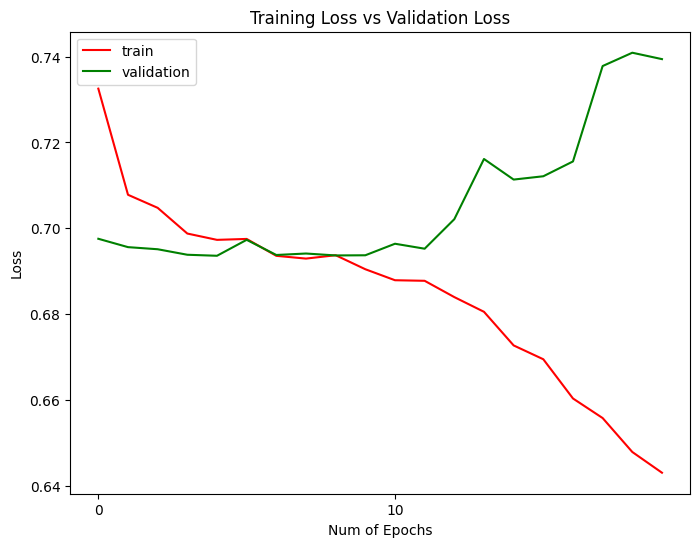

[I 2023-07-07 09:45:04,458] Trial 21 finished with value: 0.6935824155807495 and parameters: {'pT0Ref': 1.379657133064651, 'ecmPow': 0.3127620260064772, 'coreRadius': 0.6739594741124706, 'coreFraction': 0.6931935870078225}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  1.2408666290467791 0.29131266391411464 0.6833864542176911 0.6935606490636677
Pythia initialized
start
0
nCharged  2
1000
nCharged  2
2000
nCharged  256
3000
nCharged  442
4000
nCharged  30
5000
nCharged  114
6000
nCharged  2
7000
nCharged  216
8000
nCharged  2
9000
nCharged  46
(10001, 400, 3)
Max. nCharged =  704
Data shape:  (10001, 400, 3)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 64)                76864     
                                                                 
 dropout_102 (Dropout)       (None, 64)                0         
                                                                 
 dense_137 (Dense)           (None, 64)                4160      
                                                                 
 dropout_103 (Dropout)       (None, 64)                0         
                

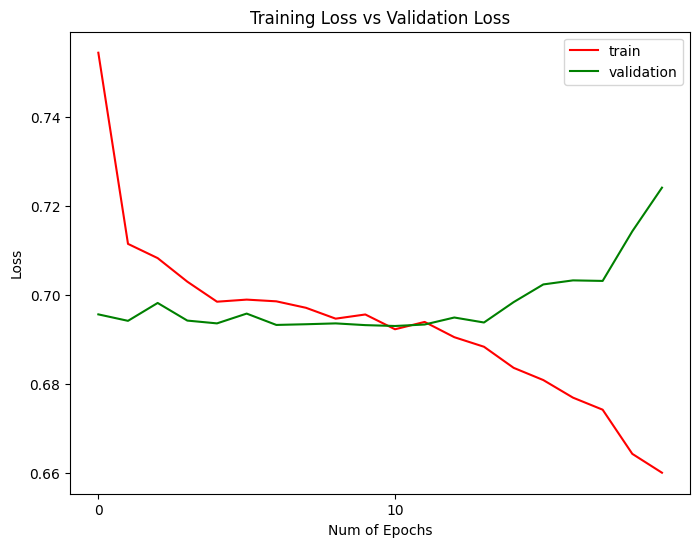

[I 2023-07-07 09:48:25,165] Trial 22 finished with value: 0.6930075287818909 and parameters: {'pT0Ref': 1.2408666290467791, 'ecmPow': 0.29131266391411464, 'coreRadius': 0.6833864542176911, 'coreFraction': 0.6935606490636677}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  0.9498835896305111 0.33090414190020984 0.5912090052051061 0.6965153484858955
Pythia initialized
start
0
nCharged  42
1000
nCharged  44
2000
nCharged  46
3000
nCharged  756
4000
nCharged  50
5000
nCharged  2
6000
nCharged  42
7000
nCharged  98
8000
nCharged  32
9000
nCharged  94
(10001, 400, 3)
Max. nCharged =  794
Data shape:  (10001, 400, 3)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 64)                76864     
                                                                 
 dropout_105 (Dropout)       (None, 64)                0         
                                                                 
 dense_141 (Dense)           (None, 64)                4160      
                                                                 
 dropout_106 (Dropout)       (None, 64)                0         
                

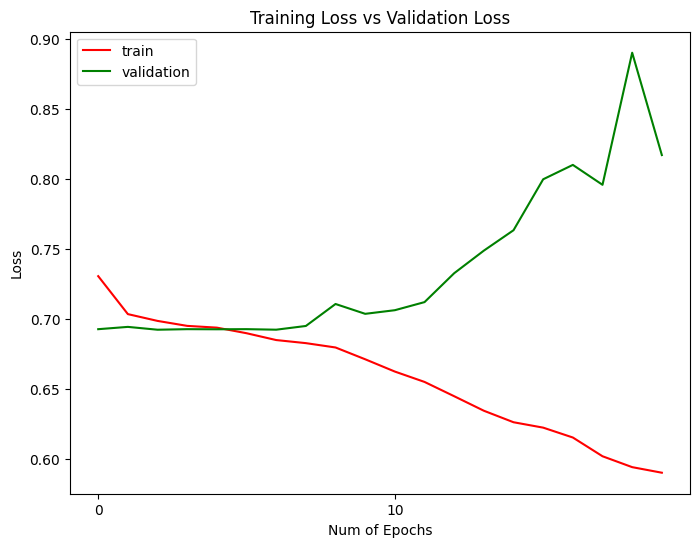

[I 2023-07-07 09:53:32,306] Trial 23 finished with value: 0.6921926736831665 and parameters: {'pT0Ref': 0.9498835896305111, 'ecmPow': 0.33090414190020984, 'coreRadius': 0.5912090052051061, 'coreFraction': 0.6965153484858955}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  1.5591498745304417 0.39456056405741136 0.5578424163958242 0.6939210867786365
Pythia initialized
start
0
nCharged  92
1000
nCharged  310
2000
nCharged  6
3000
nCharged  2
4000
nCharged  60
5000
nCharged  2
6000
nCharged  132
7000
nCharged  32
8000
nCharged  2
9000
nCharged  240
(10001, 400, 3)
Max. nCharged =  590
Data shape:  (10001, 400, 3)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 64)                76864     
                                                                 
 dropout_108 (Dropout)       (None, 64)                0         
                                                                 
 dense_145 (Dense)           (None, 64)                4160      
                                                                 
 dropout_109 (Dropout)       (None, 64)                0         
                 

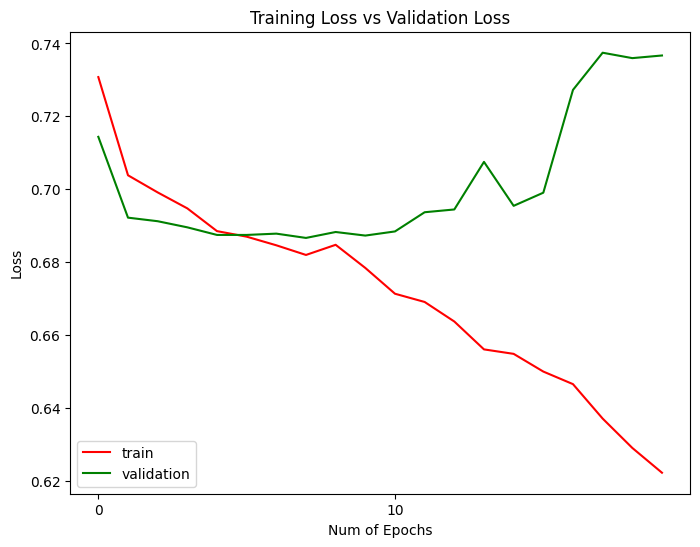

[I 2023-07-07 09:56:48,492] Trial 24 finished with value: 0.6866331696510315 and parameters: {'pT0Ref': 1.5591498745304417, 'ecmPow': 0.39456056405741136, 'coreRadius': 0.5578424163958242, 'coreFraction': 0.6939210867786365}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  1.9586666638455148 0.2974618491294071 0.6912082333862289 0.6923791423553732
Pythia initialized
start
0
nCharged  38
1000
nCharged  14
2000
nCharged  46
3000
nCharged  102
4000
nCharged  54
5000
nCharged  30
6000
nCharged  2
7000
nCharged  140
8000
nCharged  16
9000
nCharged  220
(10001, 400, 3)
Max. nCharged =  532
Data shape:  (10001, 400, 3)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 64)                76864     
                                                                 
 dropout_111 (Dropout)       (None, 64)                0         
                                                                 
 dense_149 (Dense)           (None, 64)                4160      
                                                                 
 dropout_112 (Dropout)       (None, 64)                0         
               

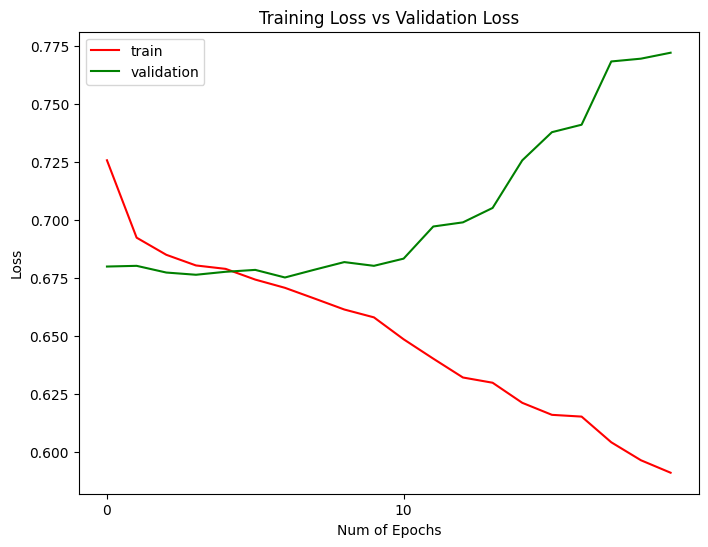

[I 2023-07-07 09:59:31,780] Trial 25 finished with value: 0.675076425075531 and parameters: {'pT0Ref': 1.9586666638455148, 'ecmPow': 0.2974618491294071, 'coreRadius': 0.6912082333862289, 'coreFraction': 0.6923791423553732}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  0.6973109376865954 0.33245717995825463 0.8480292253004307 0.6939687160108023
Pythia initialized
start
0
nCharged  40
1000
nCharged  78
2000
nCharged  2
3000
nCharged  364
4000
nCharged  68
5000
nCharged  2
6000
nCharged  60
7000
nCharged  34
8000
nCharged  2
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  876
Data shape:  (10001, 400, 3)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_152 (Dense)           (None, 64)                76864     
                                                                 
 dropout_114 (Dropout)       (None, 64)                0         
                                                                 
 dense_153 (Dense)           (None, 64)                4160      
                                                                 
 dropout_115 (Dropout)       (None, 64)                0         
                   

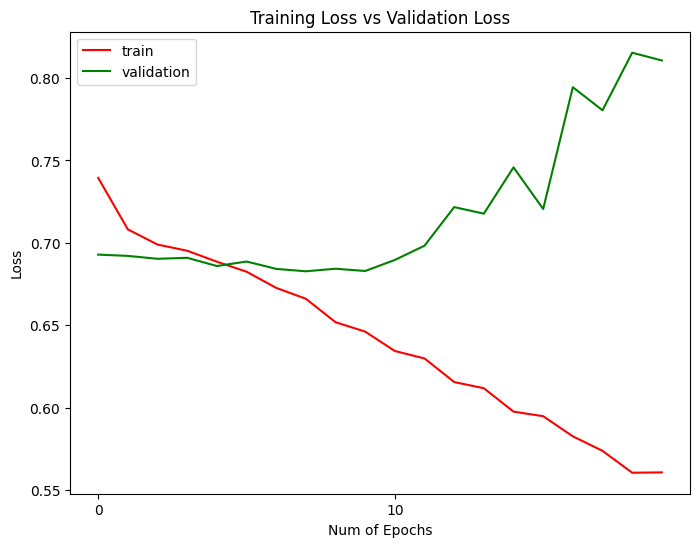

[I 2023-07-07 10:12:18,231] Trial 26 finished with value: 0.6827701926231384 and parameters: {'pT0Ref': 0.6973109376865954, 'ecmPow': 0.33245717995825463, 'coreRadius': 0.8480292253004307, 'coreFraction': 0.6939687160108023}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  1.2413871186754781 0.2715874190387032 0.713292306869722 0.6913929007185127
Pythia initialized
start
0
nCharged  2
1000
nCharged  406
2000
nCharged  6
3000
nCharged  50
4000
nCharged  2
5000
nCharged  262
6000
nCharged  36
7000
nCharged  2
8000
nCharged  46
9000
nCharged  46
(10001, 400, 3)
Max. nCharged =  718
Data shape:  (10001, 400, 3)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 64)                76864     
                                                                 
 dropout_117 (Dropout)       (None, 64)                0         
                                                                 
 dense_157 (Dense)           (None, 64)                4160      
                                                                 
 dropout_118 (Dropout)       (None, 64)                0         
                    

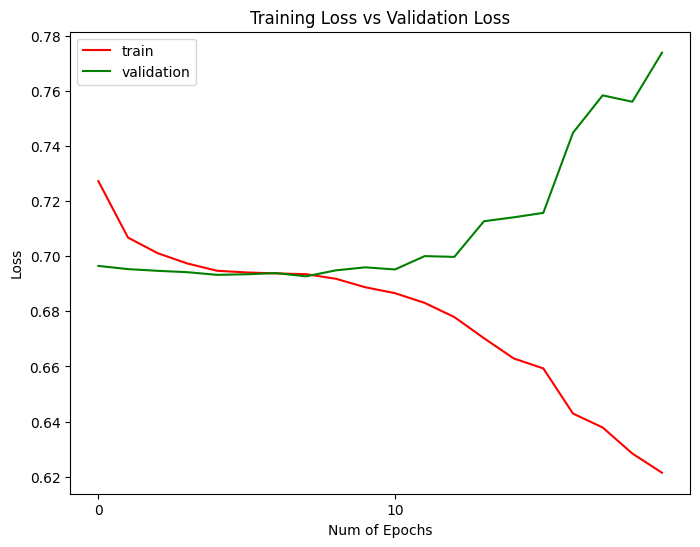

[I 2023-07-07 10:15:42,636] Trial 27 finished with value: 0.6927036643028259 and parameters: {'pT0Ref': 1.2413871186754781, 'ecmPow': 0.2715874190387032, 'coreRadius': 0.713292306869722, 'coreFraction': 0.6913929007185127}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  0.8037625063999607 0.2545832335065333 0.6257525537557826 0.6962250039067491
Pythia initialized
start
0
nCharged  198
1000
nCharged  38
2000
nCharged  346
3000
nCharged  724
4000
nCharged  12
5000
nCharged  2
6000
nCharged  2
7000
nCharged  132
8000
nCharged  120
9000
nCharged  94
(10001, 400, 3)
Max. nCharged =  826
Data shape:  (10001, 400, 3)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 64)                76864     
                                                                 
 dropout_120 (Dropout)       (None, 64)                0         
                                                                 
 dense_161 (Dense)           (None, 64)                4160      
                                                                 
 dropout_121 (Dropout)       (None, 64)                0         
              

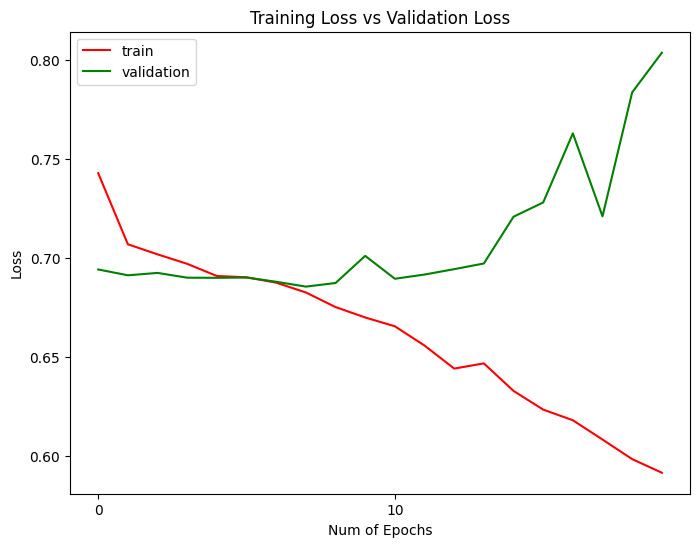

[I 2023-07-07 10:23:26,471] Trial 28 finished with value: 0.6853643655776978 and parameters: {'pT0Ref': 0.8037625063999607, 'ecmPow': 0.2545832335065333, 'coreRadius': 0.6257525537557826, 'coreFraction': 0.6962250039067491}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  1.784067541204804 0.36820503404354077 0.9958001460798285 0.6924279705116814
Pythia initialized
start
0
nCharged  2
1000
nCharged  60
2000
nCharged  78
3000
nCharged  92
4000
nCharged  30
5000
nCharged  176
6000
nCharged  76
7000
nCharged  34
8000
nCharged  108
9000
nCharged  12
(10001, 400, 3)
Max. nCharged =  522
Data shape:  (10001, 400, 3)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_164 (Dense)           (None, 64)                76864     
                                                                 
 dropout_123 (Dropout)       (None, 64)                0         
                                                                 
 dense_165 (Dense)           (None, 64)                4160      
                                                                 
 dropout_124 (Dropout)       (None, 64)                0         
                

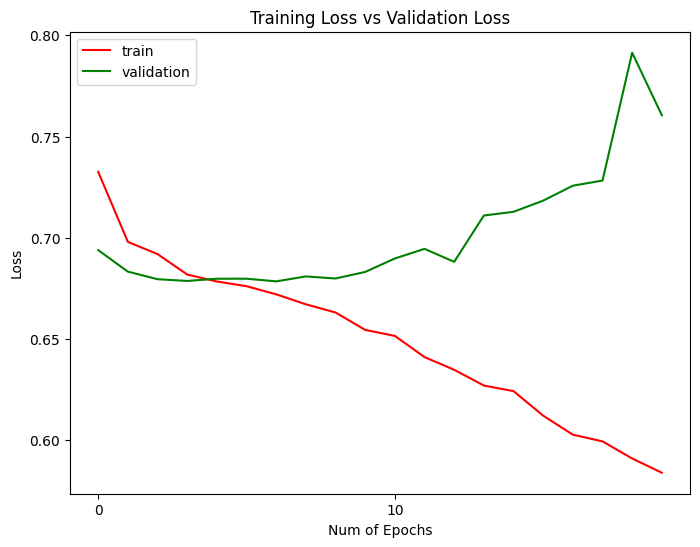

[I 2023-07-07 10:26:16,392] Trial 29 finished with value: 0.6784254312515259 and parameters: {'pT0Ref': 1.784067541204804, 'ecmPow': 0.36820503404354077, 'coreRadius': 0.9958001460798285, 'coreFraction': 0.6924279705116814}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  1.0442424667955332 0.3074610704323347 0.8667185781571515 0.6944850374788171
Pythia initialized
start
0
nCharged  40
1000
nCharged  604
2000
nCharged  2
3000
nCharged  28
4000
nCharged  2
5000
nCharged  192
6000
nCharged  114
7000
nCharged  148
8000
nCharged  356
9000
nCharged  86
(10001, 400, 3)
Max. nCharged =  752
Data shape:  (10001, 400, 3)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 64)                76864     
                                                                 
 dropout_126 (Dropout)       (None, 64)                0         
                                                                 
 dense_169 (Dense)           (None, 64)                4160      
                                                                 
 dropout_127 (Dropout)       (None, 64)                0         
              

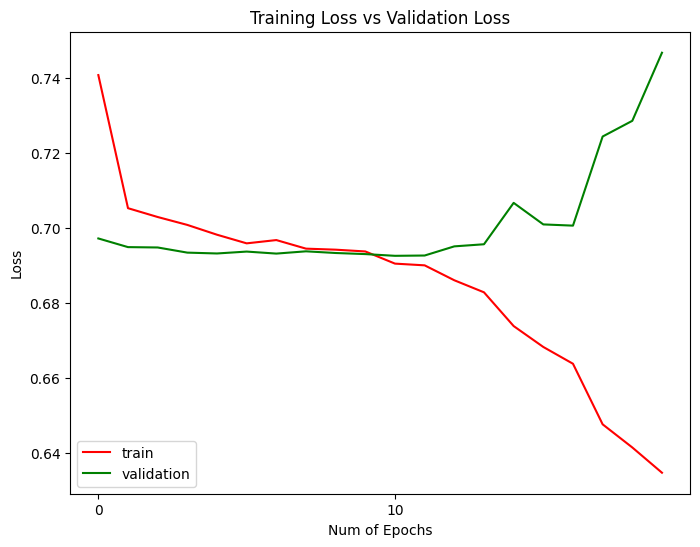

[I 2023-07-07 10:30:20,008] Trial 30 finished with value: 0.6925840377807617 and parameters: {'pT0Ref': 1.0442424667955332, 'ecmPow': 0.3074610704323347, 'coreRadius': 0.8667185781571515, 'coreFraction': 0.6944850374788171}. Best is trial 21 with value: 0.6935824155807495.


Optuna suggested x =  1.2824647102365447 0.28338142010171313 0.7215158343310076 0.6933473187572359
Pythia initialized
start
0
nCharged  90
1000
nCharged  200
2000
nCharged  50
3000
nCharged  36
4000
nCharged  118
5000
nCharged  16
6000
nCharged  376
7000
nCharged  404
8000
nCharged  56
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  694
Data shape:  (10001, 400, 3)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 64)                76864     
                                                                 
 dropout_129 (Dropout)       (None, 64)                0         
                                                                 
 dense_173 (Dense)           (None, 64)                4160      
                                                                 
 dropout_130 (Dropout)       (None, 64)                0         
             

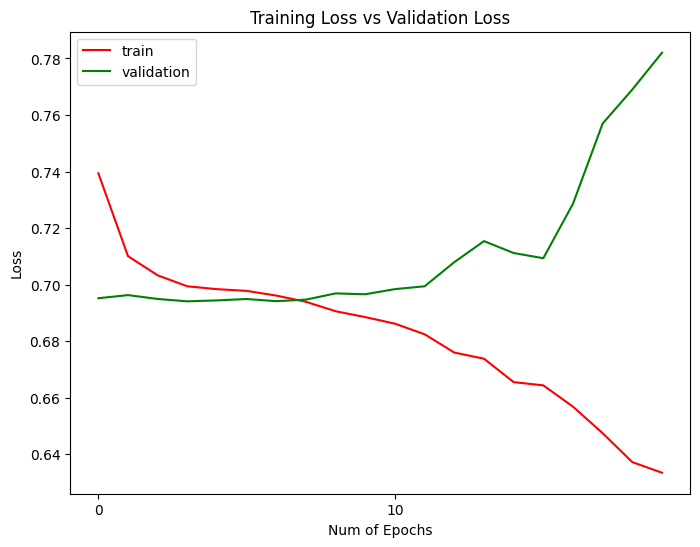

[I 2023-07-07 10:33:43,375] Trial 31 finished with value: 0.6940470933914185 and parameters: {'pT0Ref': 1.2824647102365447, 'ecmPow': 0.28338142010171313, 'coreRadius': 0.7215158343310076, 'coreFraction': 0.6933473187572359}. Best is trial 31 with value: 0.6940470933914185.


Optuna suggested x =  1.650865030839836 0.28188953056057103 0.7288180127331882 0.6974759899789603
Pythia initialized
start
0
nCharged  202
1000
nCharged  72
2000
nCharged  10
3000
nCharged  98
4000
nCharged  288
5000
nCharged  62
6000
nCharged  2
7000
nCharged  134
8000
nCharged  72
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  558
Data shape:  (10001, 400, 3)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_176 (Dense)           (None, 64)                76864     
                                                                 
 dropout_132 (Dropout)       (None, 64)                0         
                                                                 
 dense_177 (Dense)           (None, 64)                4160      
                                                                 
 dropout_133 (Dropout)       (None, 64)                0         
                

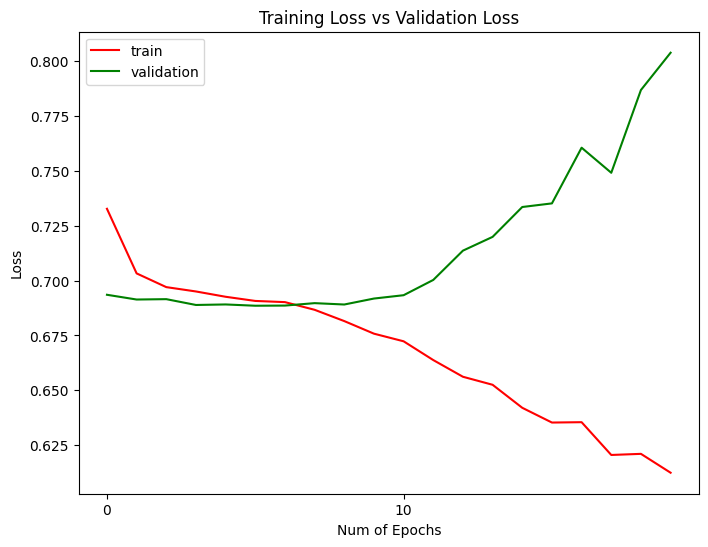

[I 2023-07-07 10:36:39,168] Trial 32 finished with value: 0.6885293126106262 and parameters: {'pT0Ref': 1.650865030839836, 'ecmPow': 0.28188953056057103, 'coreRadius': 0.7288180127331882, 'coreFraction': 0.6974759899789603}. Best is trial 31 with value: 0.6940470933914185.


Optuna suggested x =  1.1926538358185723 0.33826942732161963 0.646752221989987 0.6936041157651603
Pythia initialized
start
0
nCharged  36
1000
nCharged  2
2000
nCharged  58
3000
nCharged  78
4000
nCharged  56
5000
nCharged  38
6000
nCharged  36
7000
nCharged  198
8000
nCharged  76
9000
nCharged  128
(10001, 400, 3)
Max. nCharged =  722
Data shape:  (10001, 400, 3)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 64)                76864     
                                                                 
 dropout_135 (Dropout)       (None, 64)                0         
                                                                 
 dense_181 (Dense)           (None, 64)                4160      
                                                                 
 dropout_136 (Dropout)       (None, 64)                0         
                

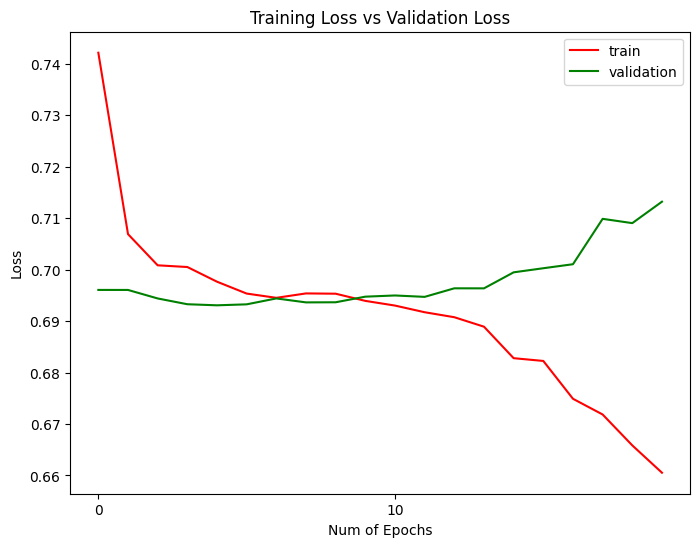

[I 2023-07-07 10:40:23,651] Trial 33 finished with value: 0.6930704712867737 and parameters: {'pT0Ref': 1.1926538358185723, 'ecmPow': 0.33826942732161963, 'coreRadius': 0.646752221989987, 'coreFraction': 0.6936041157651603}. Best is trial 31 with value: 0.6940470933914185.


Optuna suggested x =  1.3543548583090688 0.3141490309873506 0.778884339562369 0.6915279346817069
Pythia initialized
start
0
nCharged  6
1000
nCharged  498
2000
nCharged  184
3000
nCharged  2
4000
nCharged  2
5000
nCharged  2
6000
nCharged  2
7000
nCharged  34
8000
nCharged  18
9000
nCharged  2
(10001, 400, 3)
Max. nCharged =  666
Data shape:  (10001, 400, 3)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 64)                76864     
                                                                 
 dropout_138 (Dropout)       (None, 64)                0         
                                                                 
 dense_185 (Dense)           (None, 64)                4160      
                                                                 
 dropout_139 (Dropout)       (None, 64)                0         
                      

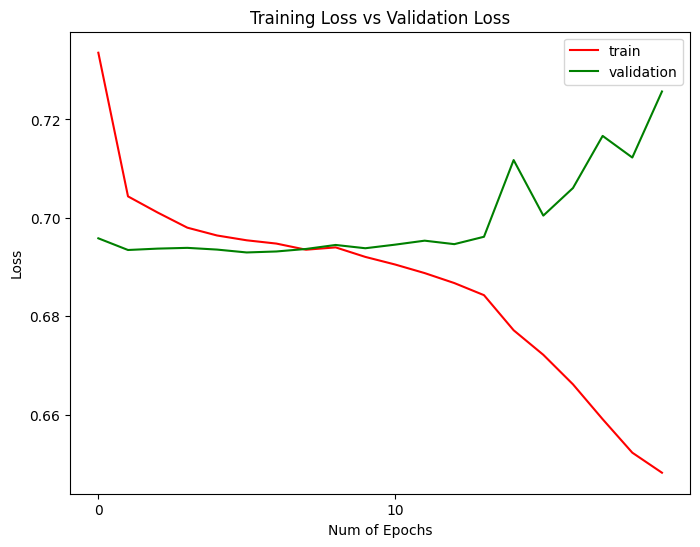

[I 2023-07-07 10:43:36,754] Trial 34 finished with value: 0.6929620504379272 and parameters: {'pT0Ref': 1.3543548583090688, 'ecmPow': 0.3141490309873506, 'coreRadius': 0.778884339562369, 'coreFraction': 0.6915279346817069}. Best is trial 31 with value: 0.6940470933914185.


Optuna suggested x =  1.6067654600728192 0.3577640671032987 0.6971578431782967 0.6956227088109334
Pythia initialized
start
0
nCharged  2
1000
nCharged  44
2000
nCharged  2
3000
nCharged  52
4000
nCharged  2
5000
nCharged  2
6000
nCharged  6
7000
nCharged  38
8000
nCharged  28
9000
nCharged  80
(10001, 400, 3)
Max. nCharged =  588
Data shape:  (10001, 400, 3)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 64)                76864     
                                                                 
 dropout_141 (Dropout)       (None, 64)                0         
                                                                 
 dense_189 (Dense)           (None, 64)                4160      
                                                                 
 dropout_142 (Dropout)       (None, 64)                0         
                      

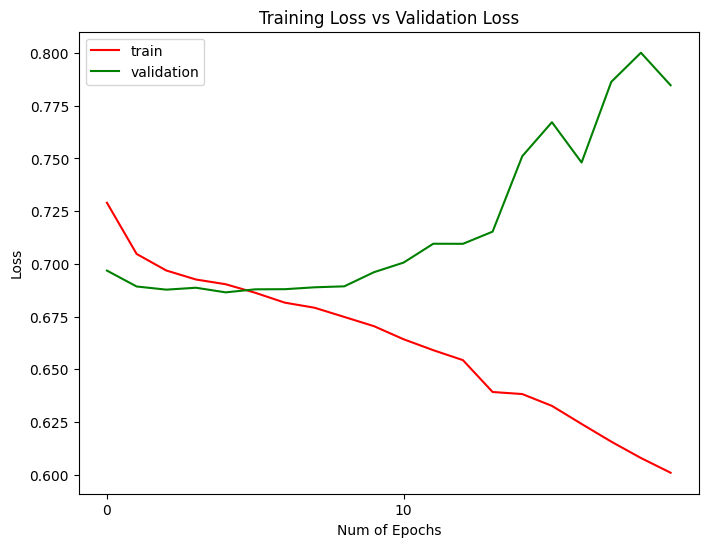

[I 2023-07-07 10:46:34,741] Trial 35 finished with value: 0.6864762306213379 and parameters: {'pT0Ref': 1.6067654600728192, 'ecmPow': 0.3577640671032987, 'coreRadius': 0.6971578431782967, 'coreFraction': 0.6956227088109334}. Best is trial 31 with value: 0.6940470933914185.


Optuna suggested x =  1.4076086554109422 0.29957257212918514 0.6020243413445837 0.6969281627813871
Pythia initialized
start
0
nCharged  2
1000
nCharged  44
2000
nCharged  178
3000
nCharged  50
4000
nCharged  2
5000
nCharged  214
6000
nCharged  2
7000
nCharged  84
8000
nCharged  326
9000
nCharged  544
(10001, 400, 3)
Max. nCharged =  616
Data shape:  (10001, 400, 3)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 64)                76864     
                                                                 
 dropout_144 (Dropout)       (None, 64)                0         
                                                                 
 dense_193 (Dense)           (None, 64)                4160      
                                                                 
 dropout_145 (Dropout)       (None, 64)                0         
               

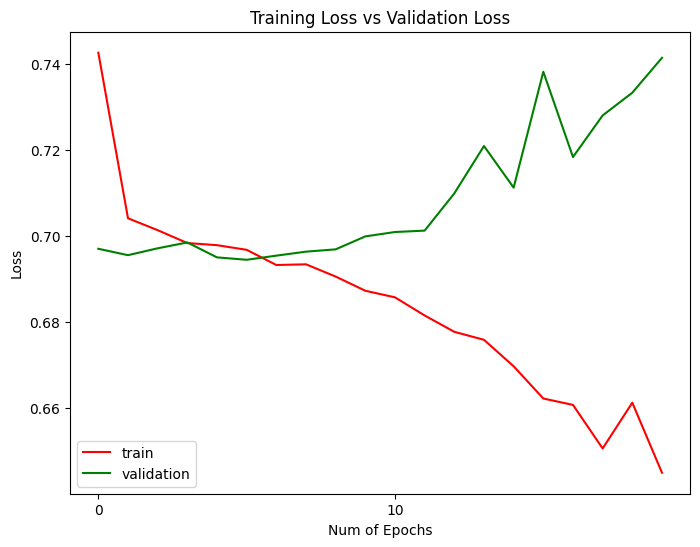

[I 2023-07-07 10:49:43,505] Trial 36 finished with value: 0.6945466995239258 and parameters: {'pT0Ref': 1.4076086554109422, 'ecmPow': 0.29957257212918514, 'coreRadius': 0.6020243413445837, 'coreFraction': 0.6969281627813871}. Best is trial 36 with value: 0.6945466995239258.


Optuna suggested x =  2.05924219975285 0.3008289782016032 0.5164858481885926 0.6969178335526486
Pythia initialized
start
0
nCharged  2
1000
nCharged  200
2000
nCharged  86
3000
nCharged  2
4000
nCharged  52
5000
nCharged  44
6000
nCharged  2
7000
nCharged  2
8000
nCharged  2
9000
nCharged  56
(10001, 400, 3)
Max. nCharged =  538
Data shape:  (10001, 400, 3)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 64)                76864     
                                                                 
 dropout_147 (Dropout)       (None, 64)                0         
                                                                 
 dense_197 (Dense)           (None, 64)                4160      
                                                                 
 dropout_148 (Dropout)       (None, 64)                0         
                       

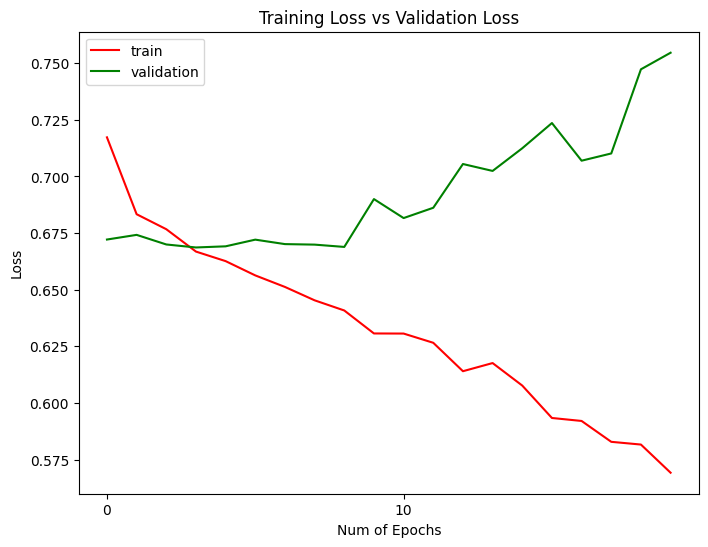

[I 2023-07-07 10:52:28,823] Trial 37 finished with value: 0.6686286926269531 and parameters: {'pT0Ref': 2.05924219975285, 'ecmPow': 0.3008289782016032, 'coreRadius': 0.5164858481885926, 'coreFraction': 0.6969178335526486}. Best is trial 36 with value: 0.6945466995239258.


Optuna suggested x =  0.795833352770583 0.34275847411051974 0.9081034377458139 0.6982007861919944
Pythia initialized
start
0
nCharged  194
1000
nCharged  310
2000
nCharged  16
3000
nCharged  2
4000
nCharged  44
5000
nCharged  218
6000
nCharged  506
7000
nCharged  380
8000
nCharged  190
9000
nCharged  438
(10001, 400, 3)
Max. nCharged =  814
Data shape:  (10001, 400, 3)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 64)                76864     
                                                                 
 dropout_150 (Dropout)       (None, 64)                0         
                                                                 
 dense_201 (Dense)           (None, 64)                4160      
                                                                 
 dropout_151 (Dropout)       (None, 64)                0         
           

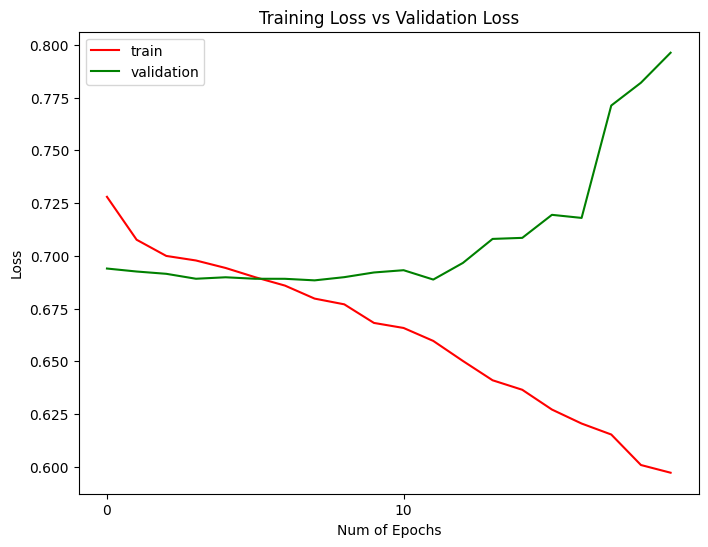

[I 2023-07-07 11:00:18,823] Trial 38 finished with value: 0.6883514523506165 and parameters: {'pT0Ref': 0.795833352770583, 'ecmPow': 0.34275847411051974, 'coreRadius': 0.9081034377458139, 'coreFraction': 0.6982007861919944}. Best is trial 36 with value: 0.6945466995239258.


Optuna suggested x =  1.4536350731006529 0.3239991720581753 0.762527493620178 0.6929385467868392
Pythia initialized
start
0
nCharged  48
1000
nCharged  2
2000
nCharged  80
3000
nCharged  150
4000
nCharged  120
5000
nCharged  116
6000
nCharged  226
7000
nCharged  182
8000
nCharged  2
9000
nCharged  310
(10001, 400, 3)
Max. nCharged =  632
Data shape:  (10001, 400, 3)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 64)                76864     
                                                                 
 dropout_153 (Dropout)       (None, 64)                0         
                                                                 
 dense_205 (Dense)           (None, 64)                4160      
                                                                 
 dropout_154 (Dropout)       (None, 64)                0         
              

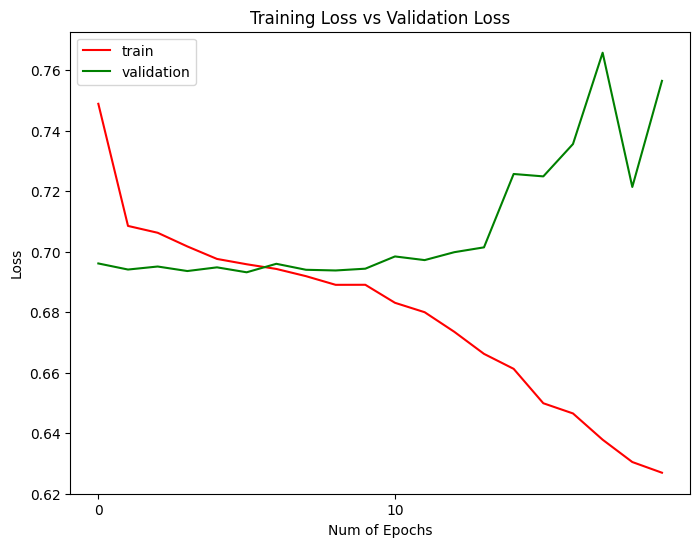

[I 2023-07-07 11:03:22,632] Trial 39 finished with value: 0.6931393146514893 and parameters: {'pT0Ref': 1.4536350731006529, 'ecmPow': 0.3239991720581753, 'coreRadius': 0.762527493620178, 'coreFraction': 0.6929385467868392}. Best is trial 36 with value: 0.6945466995239258.


{'pT0Ref': 1.4076086554109422,
 'ecmPow': 0.29957257212918514,
 'coreRadius': 0.6020243413445837,
 'coreFraction': 0.6969281627813871}

In [79]:
n_trials=40

def objective(trial):
    pT0Ref = trial.suggest_float('pT0Ref', 0.5, 4)
    ecmPow = trial.suggest_float('ecmPow', 0.1, 0.4)
    coreRadius = trial.suggest_float('coreRadius', 0.1, 1.0)
    coreFraction = trial.suggest_float('coreFraction', 0.69, 0.71)
    print("Optuna suggested x = ",pT0Ref, ecmPow, coreRadius, coreFraction)
    loss = optimize(data0, pT0Ref, ecmPow, coreRadius, coreFraction)
    return loss

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

study.best_params 

In [89]:
study.best_trials

[FrozenTrial(number=36, state=TrialState.COMPLETE, values=[0.6945466995239258], datetime_start=datetime.datetime(2023, 7, 7, 10, 46, 34, 742718), datetime_complete=datetime.datetime(2023, 7, 7, 10, 49, 43, 505231), params={'pT0Ref': 1.4076086554109422, 'ecmPow': 0.29957257212918514, 'coreRadius': 0.6020243413445837, 'coreFraction': 0.6969281627813871}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'pT0Ref': FloatDistribution(high=4.0, log=False, low=0.5, step=None), 'ecmPow': FloatDistribution(high=0.4, log=False, low=0.1, step=None), 'coreRadius': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'coreFraction': FloatDistribution(high=0.71, log=False, low=0.69, step=None)}, trial_id=36, value=None)]

In [90]:
study.best_params

{'pT0Ref': 1.4076086554109422,
 'ecmPow': 0.29957257212918514,
 'coreRadius': 0.6020243413445837,
 'coreFraction': 0.6969281627813871}

/tmp/ipykernel_145440/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

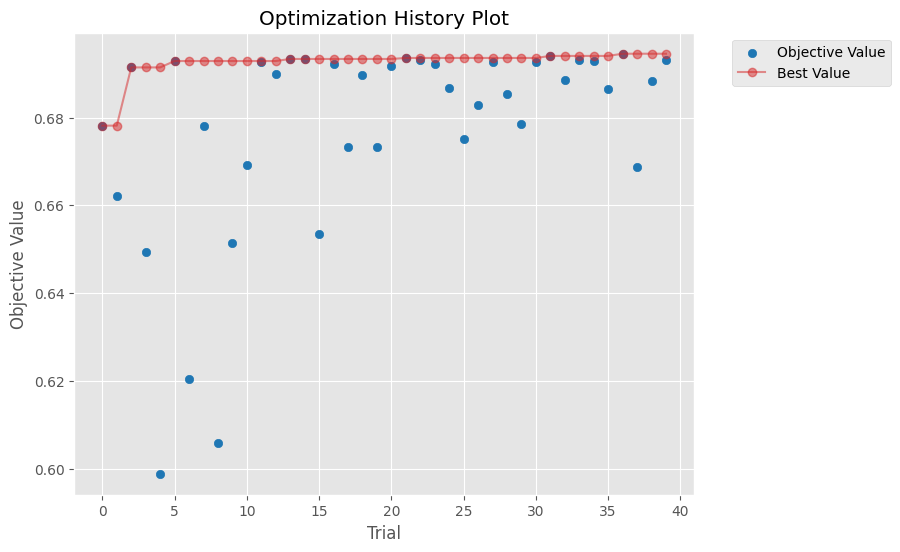

In [81]:
plot_optimization_history(study)

/tmp/ipykernel_145440/3988485508.py:1: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(study)
[W 2023-07-07 11:03:22,935] You need to set up the pruning feature to utilize `plot_intermediate_values()`


<Axes: title={'center': 'Intermediate Values Plot'}, xlabel='Step', ylabel='Intermediate Value'>

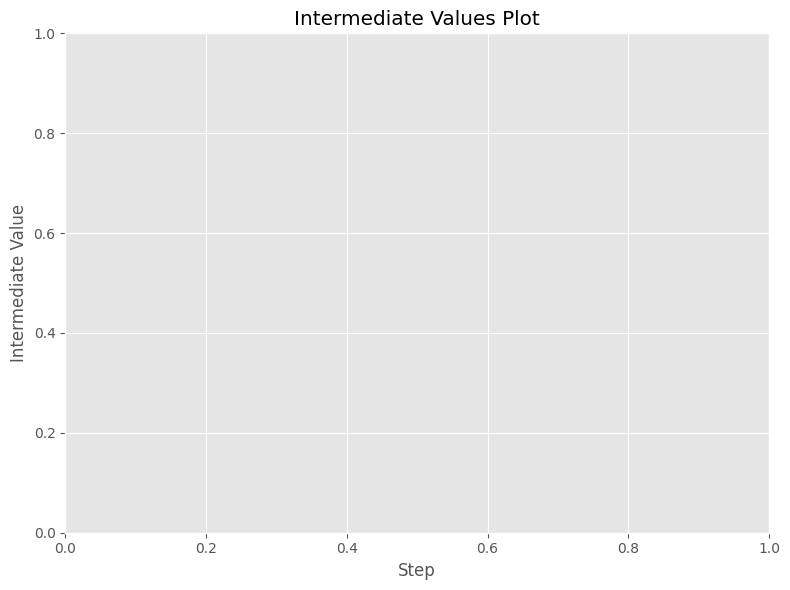

In [82]:
plot_intermediate_values(study)

/tmp/ipykernel_145440/4291280223.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


<Axes: title={'center': 'Parallel Coordinate Plot'}>

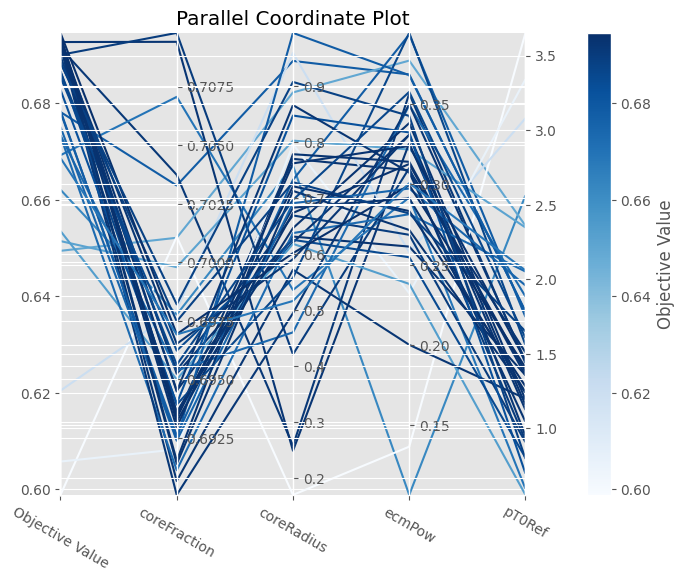

In [83]:
plot_parallel_coordinate(study)

/tmp/ipykernel_145440/927314822.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2023-07-07 11:03:23,959] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<Axes: ylabel='coreFraction'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='coreRadius'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='ecmPow'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='coreFraction', ylabel='pT0Ref'>,
        <Axes: xlabel='coreRadius'>, <Axes: xlabel='ecmPow'>,
        <Axes: xlabel='pT0Ref'>]], dtype=object)

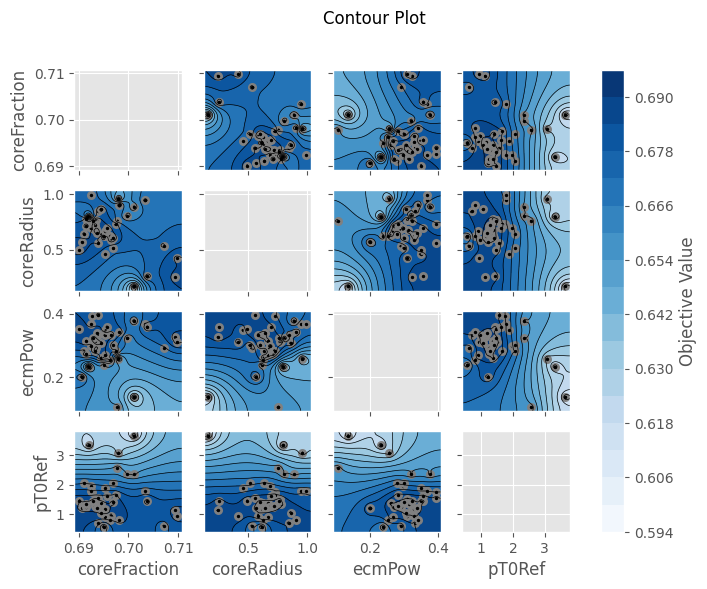

In [84]:
plot_contour(study)

/tmp/ipykernel_145440/2457830863.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='coreFraction', ylabel='Objective Value'>,
       <Axes: xlabel='coreRadius'>, <Axes: xlabel='ecmPow'>,
       <Axes: xlabel='pT0Ref'>], dtype=object)

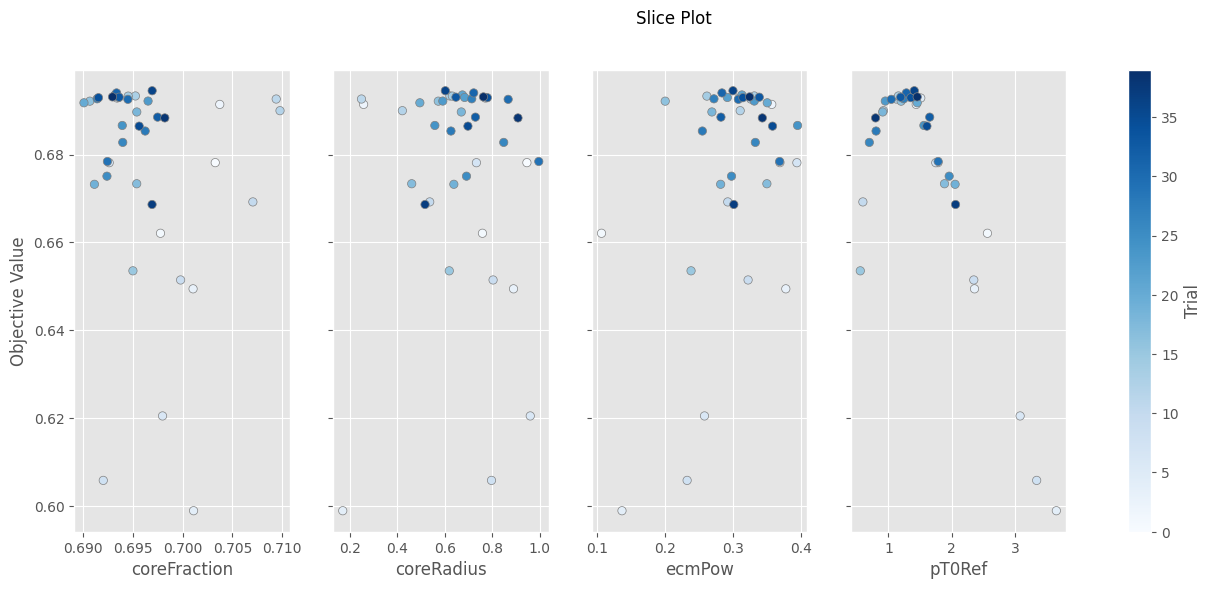

In [85]:
plot_slice(study)

/tmp/ipykernel_145440/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

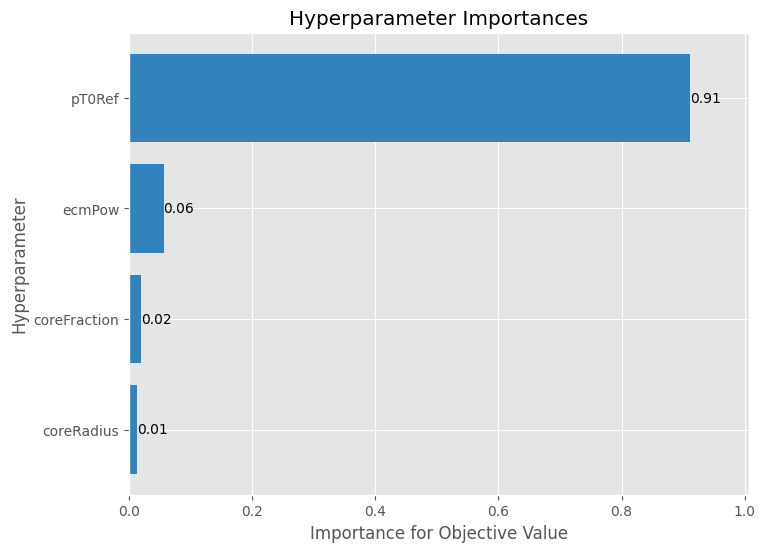

In [86]:
plot_param_importances(study)